# Setup

In [1]:
from pycqed.analysis import measurement_analysis as ma
import itertools
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import *
import numpy as np
from pycqed.measurement import qaoa
from pycqed.analysis import analysis_toolbox as a_tools
a_tools.datadir = "X:"
figsave_base = "C:\\Users\\nathan\\projects\\master_thesis\\chapters\\qaoa\\figs\\"

c:\users\nathan\code\quantumsoftware\pycqed_py3\data
Data directory set to: c:\users\nathan\code\quantumsoftware\pycqed_py3\data


## plotting style

In [2]:
fig_size_dim    = 8
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 16
    marker_size     = 6
    line_width      = 2.5
    axes_line_width = 1
    tick_length     = 5
    tick_width      = 1
    tick_color      = 'k'
    ticks_direction = 'in'
    axes_labelcolor = 'k'
    dpi             =  800

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "DIN Pro",#"cmss10", #"DINPro", # to manage to use dinpro, put ttf files in site-packages/matplotlib/mpl-data/fonts
              'mathtext.default': 'it',
              'mathtext.fontset': "cm",
              'mathtext.it': 'cm',
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.labelcolor': axes_labelcolor,
              'axes.titlesize': font_size,
              'axes.linewidth': axes_line_width,
              'lines.markersize': marker_size,
              'lines.linewidth': line_width,
              'xtick.direction': ticks_direction,
              'ytick.direction': ticks_direction,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'xtick.color': tick_color,
              'ytick.color': tick_color,
              'xtick.major.size': tick_length,
              'ytick.major.size': tick_length,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.top': True,
              'xtick.bottom': True,
              'ytick.left': True,
              'ytick.right': True,
              'axes.formatter.useoffset': False,
              'pdf.fonttype' : 42, 
              'ps.fonttype' : 42,

              # LEGEND
            'legend.loc'           : 'best',
            'legend.frameon'       : False,     ## if True, draw the legend on a background patch
    #         'legend.framealpha'    : 0.8,      ## legend patch transparency
    #         'legend.facecolor'     : 'inherit',  ## inherit from axes.facecolor; or color spec
    #         'legend.edgecolor'     : 0.8,      ## background patch boundary color
    #         'legend.fancybox'      : True,     ## if True, use a rounded box for the
                                             ## legend background, else a rectangle
                }

    plt.rcParams.update(params)
plot_style()


In [3]:
# unit to have radians in plots
"""
===========
Basic Units, used to display axis in units of pi
===========

"""

import math

import numpy as np

import matplotlib.units as units
import matplotlib.ticker as ticker


class ProxyDelegate(object):
    def __init__(self, fn_name, proxy_type):
        self.proxy_type = proxy_type
        self.fn_name = fn_name

    def __get__(self, obj, objtype=None):
        return self.proxy_type(self.fn_name, obj)


class TaggedValueMeta(type):
    def __init__(self, name, bases, dict):
        for fn_name in self._proxies:
            try:
                dummy = getattr(self, fn_name)
            except AttributeError:
                setattr(self, fn_name,
                        ProxyDelegate(fn_name, self._proxies[fn_name]))


class PassThroughProxy(object):
    def __init__(self, fn_name, obj):
        self.fn_name = fn_name
        self.target = obj.proxy_target

    def __call__(self, *args):
        fn = getattr(self.target, self.fn_name)
        ret = fn(*args)
        return ret


class ConvertArgsProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        for a in args:
            try:
                converted_args.append(a.convert_to(self.unit))
            except AttributeError:
                converted_args.append(TaggedValue(a, self.unit))
        converted_args = tuple([c.get_value() for c in converted_args])
        return PassThroughProxy.__call__(self, *converted_args)


class ConvertReturnProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        ret = PassThroughProxy.__call__(self, *args)
        return (NotImplemented if ret is NotImplemented
                else TaggedValue(ret, self.unit))


class ConvertAllProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        arg_units = [self.unit]
        for a in args:
            if hasattr(a, 'get_unit') and not hasattr(a, 'convert_to'):
                # if this arg has a unit type but no conversion ability,
                # this operation is prohibited
                return NotImplemented

            if hasattr(a, 'convert_to'):
                try:
                    a = a.convert_to(self.unit)
                except Exception:
                    pass
                arg_units.append(a.get_unit())
                converted_args.append(a.get_value())
            else:
                converted_args.append(a)
                if hasattr(a, 'get_unit'):
                    arg_units.append(a.get_unit())
                else:
                    arg_units.append(None)
        converted_args = tuple(converted_args)
        ret = PassThroughProxy.__call__(self, *converted_args)
        if ret is NotImplemented:
            return NotImplemented
        ret_unit = unit_resolver(self.fn_name, arg_units)
        if ret_unit is NotImplemented:
            return NotImplemented
        return TaggedValue(ret, ret_unit)


class TaggedValue(metaclass=TaggedValueMeta):

    _proxies = {'__add__': ConvertAllProxy,
                '__sub__': ConvertAllProxy,
                '__mul__': ConvertAllProxy,
                '__rmul__': ConvertAllProxy,
                '__cmp__': ConvertAllProxy,
                '__lt__': ConvertAllProxy,
                '__gt__': ConvertAllProxy,
                '__len__': PassThroughProxy}

    def __new__(cls, value, unit):
        # generate a new subclass for value
        value_class = type(value)
        try:
            subcls = type(f'TaggedValue_of_{value_class.__name__}',
                          (cls, value_class), {})
            if subcls not in units.registry:
                units.registry[subcls] = basicConverter
            return object.__new__(subcls)
        except TypeError:
            if cls not in units.registry:
                units.registry[cls] = basicConverter
            return object.__new__(cls)

    def __init__(self, value, unit):
        self.value = value
        self.unit = unit
        self.proxy_target = self.value

    def __getattribute__(self, name):
        if name.startswith('__'):
            return object.__getattribute__(self, name)
        variable = object.__getattribute__(self, 'value')
        if hasattr(variable, name) and name not in self.__class__.__dict__:
            return getattr(variable, name)
        return object.__getattribute__(self, name)

    def __array__(self, dtype=object):
        return np.asarray(self.value).astype(dtype)

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self.unit)

    def __repr__(self):
        return 'TaggedValue({!r}, {!r})'.format(self.value, self.unit)

    def __str__(self):
        return str(self.value) + ' in ' + str(self.unit)

    def __len__(self):
        return len(self.value)

    def __iter__(self):
        # Return a generator expression rather than use `yield`, so that
        # TypeError is raised by iter(self) if appropriate when checking for
        # iterability.
        return (TaggedValue(inner, self.unit) for inner in self.value)

    def get_compressed_copy(self, mask):
        new_value = np.ma.masked_array(self.value, mask=mask).compressed()
        return TaggedValue(new_value, self.unit)

    def convert_to(self, unit):
        if unit == self.unit or not unit:
            return self
        try:
            new_value = self.unit.convert_value_to(self.value, unit)
        except AttributeError:
            new_value = self
        return TaggedValue(new_value, unit)

    def get_value(self):
        return self.value

    def get_unit(self):
        return self.unit


class BasicUnit(object):
    def __init__(self, name, fullname=None):
        self.name = name
        if fullname is None:
            fullname = name
        self.fullname = fullname
        self.conversions = dict()

    def __repr__(self):
        return f'BasicUnit({self.name})'

    def __str__(self):
        return self.fullname

    def __call__(self, value):
        return TaggedValue(value, self)

    def __mul__(self, rhs):
        value = rhs
        unit = self
        if hasattr(rhs, 'get_unit'):
            value = rhs.get_value()
            unit = rhs.get_unit()
            unit = unit_resolver('__mul__', (self, unit))
        if unit is NotImplemented:
            return NotImplemented
        return TaggedValue(value, unit)

    def __rmul__(self, lhs):
        return self*lhs

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self)

    def __array__(self, t=None, context=None):
        ret = np.array([1])
        if t is not None:
            return ret.astype(t)
        else:
            return ret

    def add_conversion_factor(self, unit, factor):
        def convert(x):
            return x*factor
        self.conversions[unit] = convert

    def add_conversion_fn(self, unit, fn):
        self.conversions[unit] = fn

    def get_conversion_fn(self, unit):
        return self.conversions[unit]

    def convert_value_to(self, value, unit):
        conversion_fn = self.conversions[unit]
        ret = conversion_fn(value)
        return ret

    def get_unit(self):
        return self


class UnitResolver(object):
    def addition_rule(self, units):
        for unit_1, unit_2 in zip(units[:-1], units[1:]):
            if unit_1 != unit_2:
                return NotImplemented
        return units[0]

    def multiplication_rule(self, units):
        non_null = [u for u in units if u]
        if len(non_null) > 1:
            return NotImplemented
        return non_null[0]

    op_dict = {
        '__mul__': multiplication_rule,
        '__rmul__': multiplication_rule,
        '__add__': addition_rule,
        '__radd__': addition_rule,
        '__sub__': addition_rule,
        '__rsub__': addition_rule}

    def __call__(self, operation, units):
        if operation not in self.op_dict:
            return NotImplemented

        return self.op_dict[operation](self, units)


unit_resolver = UnitResolver()

cm = BasicUnit('cm', 'centimeters')
inch = BasicUnit('inch', 'inches')
inch.add_conversion_factor(cm, 2.54)
cm.add_conversion_factor(inch, 1/2.54)

radians = BasicUnit('rad', 'radians')
degrees = BasicUnit('deg', 'degrees')
radians.add_conversion_factor(degrees, 180.0/np.pi)
degrees.add_conversion_factor(radians, np.pi/180.0)

secs = BasicUnit('s', 'seconds')
hertz = BasicUnit('Hz', 'Hertz')
minutes = BasicUnit('min', 'minutes')

secs.add_conversion_fn(hertz, lambda x: 1./x)
secs.add_conversion_factor(minutes, 1/60.0)


# radians formatting
def rad_fn(x, pos=None):
    if x >= 0:
        n = int((x / np.pi) * 2.0 + 0.25)
    else:
        n = int((x / np.pi) * 2.0 - 0.25)

    if n == 0:
        return '0'
    elif n == 1:
        return r'$\pi/2$'
    elif n == 2:
        return r'$\pi$'
    elif n == -1:
        return r'$-\pi/2$'
    elif n == -2:
        return r'$-\pi$'
    elif n % 2 == 0:
        return fr'${n//2}\pi$'
    else:
        return fr'${n}\pi/2$'


class BasicUnitConverter(units.ConversionInterface):
    @staticmethod
    def axisinfo(unit, axis):
        'return AxisInfo instance for x and unit'

        if unit == radians:
            return units.AxisInfo(
                majloc=ticker.MultipleLocator(base=np.pi/2),
                majfmt=ticker.FuncFormatter(rad_fn),
                label=unit.fullname,
            )
        elif unit == degrees:
            return units.AxisInfo(
                majloc=ticker.AutoLocator(),
                majfmt=ticker.FormatStrFormatter(r'$%i^\circ$'),
                label=unit.fullname,
            )
        elif unit is not None:
            if hasattr(unit, 'fullname'):
                return units.AxisInfo(label=unit.fullname)
            elif hasattr(unit, 'unit'):
                return units.AxisInfo(label=unit.unit.fullname)
        return None

    @staticmethod
    def convert(val, unit, axis):
        if units.ConversionInterface.is_numlike(val):
            return val
        if np.iterable(val):
            if isinstance(val, np.ma.MaskedArray):
                val = val.astype(float).filled(np.nan)
            out = np.empty(len(val))
            for i, thisval in enumerate(val):
                if np.ma.is_masked(thisval):
                    out[i] = np.nan
                else:
                    try:
                        out[i] = thisval.convert_to(unit).get_value()
                    except AttributeError:
                        out[i] = thisval
            return out
        if np.ma.is_masked(val):
            return np.nan
        else:
            return val.convert_to(unit).get_value()

    @staticmethod
    def default_units(x, axis):
        'return the default unit for x or None'
        if np.iterable(x):
            for thisx in x:
                return thisx.unit
        return x.unit


def cos(x):
    if np.iterable(x):
        return [math.cos(val.convert_to(radians).get_value()) for val in x]
    else:
        return math.cos(x.convert_to(radians).get_value())


basicConverter = BasicUnitConverter()
units.registry[BasicUnit] = basicConverter
units.registry[TaggedValue] = basicConverter


## helper functions

In [4]:
def get_parameters(timestamp, all=True, gammas=False, betas=False, iteration=False, Cs=False,
                        energy=False, correlations=False, states_filtered=False):
    """
    Get relevant parameters from the measurement file. 'all' overrides all other parameters except 
        states filtered which has to be activated manually because it loads a lot of data.
    
    """
    params = {"timestamp": timestamp}
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    if all:
        gammas, betas, iteration, energy, correlations = [True]*5
    if gammas:
        params["gammas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])
    if betas:
        params["betas"] = list(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])
    if iteration:
        params["iteration"] = a.data_file["Experimental Data"]["Experimental Metadata"].attrs['iteration']
    if energy:
        params["energy"] = a.data_file['Analysis']['Processed data']['analysis_params_dict'].attrs['energy']
    if correlations:
        params["correlations"] = {n:v for n, v in zip(
            a.data_file['Analysis']['Processed data']['correlations'].attrs['names'],
            a.data_file['Analysis']['Processed data']['correlations']['values'])}
    if states_filtered:
        params["states_filtered"] = a.data_file['Analysis']['Processed data']["qb_states_filtered"]
    if Cs:
        raise NotImplementedError()
    return params

def get_parameters_run(timestamps, **kwargs):
    
    b, g, e, c, it, s = [],[],[],[], [], []
    for t in timestamps:
        params = get_parameters(t, **kwargs)
        b.append(params.get("betas", np.nan))
        g.append(params.get("gammas", np.nan))
        it.append(params.get('iteration', np.nan))
        e.append(params.get('energy', np.nan))
        c.append(params.get('correlations', np.nan))
        s.append(params.get("qb_states_filtered", np.nan))

    params_run = {}
    params_run['betas'] = np.asarray(b)
    params_run['gammas'] = np.asarray(g)
    params_run['iterations'] = np.asarray(it)
    params_run["energy"] = np.asarray(e)
    params_run["correlations"] = np.asarray(c)
    params_run["iteration_mask"] = np.asarray([e == np.amin(e[it == i]) 
                                   for i in range(max(it)+1)])
    params_run["timestamps"] = timestamps
    return params_run

def get_parameters_runs(tstart, tend, **kwargs):
    #check for label name in case interleaved tomography
    tps = a_tools.get_timestamps_in_range(tstart, tend, label="QAOA") 
    fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in tps])
    n_all_files = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    all_run_params = []
    for i, nfiles in enumerate(n_all_files):
        print(tps[np.sum(n_all_files[:i])])
#         print(len(tps))
        print(tps[np.sum(n_all_files[:i]) + nfiles-1])
#         print(n_all_files)
        tmps = a_tools.get_timestamps_in_range(tps[np.sum(n_all_files[:i])], 
                                               tps[np.sum(n_all_files[:i]) + nfiles-1])
        all_run_params.append(get_parameters_run(tmps, **kwargs))
    return all_run_params

def qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs):
    q = QubitCircuit(n_qbs, reverse_states=False)
    qubits = np.arange(n_qbs)

    assert len(Cs) == len(two_qb_pairs), f"Cs and two_qb_pairs do not match: {len(Cs) } vs {len(two_qb_pairs)}"
    
    # init
    for qb in qubits:
        q.add_gate("RY", targets=qb, arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')

    for g, b in zip(gammas, betas):
        for C, pair in zip(Cs, two_qb_pairs):
            q.add_gate("RZ", targets=pair[0], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("RZ", targets=pair[1], arg_value=-2*g*C, arg_label=r'-2\gamma C')
            q.add_gate("CPHASE", controls=pair[0], targets=pair[1], arg_value=(4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
        for k,h in enumerate(hs):
            q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

        # D
        for qb in qubits:
            q.add_gate("RX", targets=qb, arg_value=b, arg_label=r'\beta')

    U_list = q.propagators()
    return gate_sequence_product(U_list)

def cs_to_phys(labels):
    """
    changes list of labels '[0 1 0]' --> '$|010\rangle$'
    """
    labels = [str(l) for l in labels]
    return ["$|{}\\rangle$".format(l.translate({ord(i): None for i in '[() ],'})) 
            for l in labels]

def bar_plot(timestamp, gammas=None, betas=None, Cs=None, hs=None, 
             two_qb_pairs='linear_array', correct_states=None, plot=True, ax=None, save=False):
    """
    Creates histogram bar plot of measured states.
    Correct state formart: [b1 b2 ... bn]
    """
    results = {}
    
    # get qb states and parameters
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    states = np.asarray(a.data_file['Analysis']["Processed data"]["qubit_states"])
    results['states'] = states
    n_qbs = states.shape[1]
    qubits = np.arange(n_qbs)
    try:
        if gammas is None:
            gammas = a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']
        if betas is None:
            betas = a.data_file["Experimental Data"]["Experimental Metadata"]['betas']
    except TypeError:
        gammas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas'])]
        betas = [eval(a.data_file["Experimental Data"]["Experimental Metadata"]['betas'])]
    
    results["depth"] = len(gammas)
    # counts for each label
    states_labels, counts = np.unique(states, axis=0, return_counts=True)
    states_labels = np.array(cs_to_phys([str(s) for s in states_labels]))
    filter = [True if not "2" in s else False for s in states_labels]
    results["state_probs"] = {l: c for l, c in zip(states_labels[filter], counts[filter]/np.sum(counts[filter]))}
    results['leakage_prob'] = np.sum(counts[~np.array(filter, dtype=bool)])/ np.sum(counts)
    if correct_states is not None:
        correct_states = cs_to_phys(correct_states)
        counts_in_subspace = np.sum(counts[filter])
        success_prob = np.sum([counts[states_labels == c] for c in correct_states]) / counts_in_subspace
        results["success_prob"] = success_prob
        
    #qutip computation of expected state
    if Cs is None:
        _, Cs = qaoa.QAOAHelper.get_corr_and_coupl_info(
            eval(a.data_file["Experimental Data"]["Experimental Metadata"].attrs['two_qb_gates_info']))
    if hs is None:
        hs = [0 for _ in range(n_qbs)]
    if two_qb_pairs == "linear_array":
        two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] 
    else:
        raise NotImplementedError()
    
    # qutip simulation
    U = qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs)
    H = U * ket("0"*len(qubits))
    results['expected_state'] = np.real((H*H.dag()).full()[np.eye(len(H.full()), dtype=bool)])
    results["expected_state_labels"] = np.array(cs_to_phys(list(itertools.product((0,1), repeat=n_qbs))))
    if correct_states is not None:
        success_prob_theory = np.sum([results['expected_state'][results["expected_state_labels"] == c] for c in correct_states])
        results['success_prob_theory'] = success_prob_theory
        
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()
        order = list(reversed(np.argsort(counts[filter])))
        expected_state_labels_in_mmnt = [True if sl in states_labels[filter][order] else False for sl in results["expected_state_labels"]]
        ax.bar(states_labels[filter], counts[filter]/np.sum(counts[filter]),
              color='grey')
        ax.bar(results["expected_state_labels"][expected_state_labels_in_mmnt] , results['expected_state'][expected_state_labels_in_mmnt], 
               fill=False, linewidth=1, edgecolor='k', 
               label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
        if correct_states is not None:
            correct_states_counts = np.asarray([counts[states_labels == c]/np.sum(counts[filter]) for c in correct_states])
            
            ax.bar(correct_states, correct_states_counts.flatten() , 
                   color='green', label="$P_s$: {:.3f}".format(success_prob))
#             ax.legend()
        print(states_labels[filter])
        ax.xaxis.set_ticks(np.arange(len(states_labels[filter])))
        ax.xaxis.set_ticklabels(states_labels[filter],  rotation='vertical')
#         ax.set_ylabel("Fraction of measurements (arb. u.)")

        results['fig'] = fig
        if save:
            fig.tight_layout()
            fig.savefig(a.folder + "\\bit_strings_frequency.png")
            
    return results    


# Energy Landscapes

In [5]:
# landscape functions
from IPython.display import clear_output 
from copy import deepcopy
def plot_colormesh(xx, yy, zz, ax=None, labels=True, colorbar=True, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    plot_kwargs = deepcopy(plot_kwargs)
    vmin = plot_kwargs.pop("vmin", -1)
    vmax = plot_kwargs.pop("vmax", 1)
    cmap = plot_kwargs.pop("cmap", "seismic")
    im = ax.pcolormesh(np.pad(xx,(1,0), "linear_ramp"), np.pad(yy,(1,0), "linear_ramp"), zz, 
                       cmap=cmap, vmin=vmin, vmax=vmax, 
                       **plot_kwargs)
    if labels:
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
    if colorbar:
        cb = fig.colorbar(im, label=r"$\sigma_z \sigma_z$ (arb. u.)")
    return im

def load_landscape_from_npy(timestamp):
    a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
    a.data_file.close()
    gg = np.load(a.folder + "\\gammas.npy")
    bb = np.load(a.folder + "\\betas.npy")
    energy = np.load(a.folder + "\\energy.npy")
    # TODO: add leakage
    return gg, bb, energy, None, a

def load_landscape_from_analyzed_files(tstart, tend, save=False, plot=True):
    tps = a_tools.get_timestamps_in_range(tstart, tend)
    energy = []
    leakages = {}
    gammas = []
    betas = []
    an = []
    for j, t in enumerate(tps):
        print(j)
        a = ma.MeasurementAnalysis(timestamp=t, auto=False)
        gammas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']))
        betas.append(np.array(a.data_file["Experimental Data"]["Experimental Metadata"]['betas']))
        e = list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["energy"])
        for qb, leak in a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"].items():
            if qb not in leakages:
                leakages[qb] = []
            leakages[qb].append(list(a.data_file["Analysis"]["Processed data"]["analysis_params_dict"]["leakage"][qb]))
        energy.append(e)
        an.append(a)
    clear_output()
    
    gg, bb, energy =  np.asarray(gammas),  np.asarray(betas), np.asarray(energy)
    print(gg.shape)
    print(bb.shape)
    print(energy.shape)
    if save:
        f = a.folder
        np.save(f + "\\gammas.npy", gg)
        np.save(f + "\\betas.npy", bb)
        np.save(f + "\\energy.npy", energy)
        for qb in leakages:
            np.save(f + f"\\leakage_{qb}.npy", leakages[qb])
    if plot:
        # plot landscape
        fig, ax = plt.subplots()
        cmap = "seismic"
        im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), 
                           energy, cmap=cmap, vmin=-1.05, vmax=1.05)
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
        cb = fig.colorbar(im, label=r"Energy (arb. u.)")
        if save:
            fig.savefig(f + "\\energy_landscape.png")
        # plot leakage
        for qb in leakages:
            fig, ax = plt.subplots()
            im = ax.pcolormesh(np.pad(gg,(1,0), "linear_ramp"), np.pad(bb,(1,0), "linear_ramp"), leakages[qb])
            ax.set_xlabel("gamma (rad.)")
            ax.set_ylabel("beta (rad.)")
            cb = fig.colorbar(im, label=f"leakage {qb}")
            if save:
                fig.savefig(f + f"\\leakage_{qb}.png")
            
    return np.asarray(gammas), np.asarray(betas), energy, leakages, an

In [6]:
# load landscape Direct
# tstart_tend = ["20191129_111634", "20191129_135651"] # BF1
# gg_dir, bb_dir, energy_dir, leakages_dir, an_dir = load_landscape_from_analyzed_files(*tstart_tend, save=False, plot=False)
# t = "20200229_164442" # XLD Q1Q4Q2
t = "20200222_232007" # XLD Q3Q1Q4
gg_dir, bb_dir, energy_dir, _, _ = load_landscape_from_npy(t)
print(gg_dir.shape)

(45, 45)


In [34]:
# load landscape Decomposed
# tstart_tend = ["20191205_223041","20191206_010735"] # BF1
# gg_dec, bb_dec, energy_dec, leakages_dec, an_dec = load_landscape_from_analyzed_files(tstart_tend[0], tstart_tend[1], save=False, plot=False)
# t = "20200227_213611" #XLD Q1Q4
t = "20200223_205152" # XLD Q3Q1Q4
gg_dec, bb_dec, energy_dec,_,_ = load_landscape_from_npy(t)
print(gg_dec.shape)

(45, 45)


In [32]:
# noise free simulation landscape
from qutip import *

# params 
n_qbs = 3
qubits = np.arange(n_qbs)
n_points = 45
gammas = np.linspace(0,np.pi, n_points)
betas = np.linspace(0,np.pi/2, n_points)
depth=1
hs = [0, 0., 0.] # single qb terms
# two_qb_pairs = list(itertools.combinations(qubits, 2)) # full connectivity
two_qb_pairs = [(i,j) for i,j in zip(qubits, qubits[1:]) ] # linear array
Cs = [0.5, 1] 

# create two d space
gg, bb = np.meshgrid(gammas, betas, indexing="ij")

# simulate
energy = np.zeros_like(gg)
corr = {p:np.zeros_like(gg) for p in two_qb_pairs}
single_qb_term = {qb:np.zeros_like(gg) for qb in range(n_qbs)}
assert len(Cs) == len(two_qb_pairs)
for i in range(len(gammas)):
    for j in range(len(betas)):
        g = gg[i,j]
        b = bb[i,j]
        
        q = QubitCircuit(n_qbs, reverse_states=False)

        # init
        for qb in qubits:
            q.add_gate("RY", targets=int(qb), arg_value=np.pi/2, arg_label=r'\frac{\pi}{2}')
        
        for d in range(depth):
            # U
            for C, pair in zip(Cs, two_qb_pairs):
                q.add_gate("RZ", targets=int(pair[0]), arg_value=2*g*C, arg_label=r'-2\gamma C')
                q.add_gate("RZ", targets=int(pair[1]), arg_value=2*g*C, arg_label=r'-2\gamma C')
                q.add_gate("CPHASE", controls=int(pair[0]), targets=int(pair[1]), arg_value=(-4*g*C) % (2*np.pi), arg_label=r'4\gamma C')
            for k,h in enumerate(hs):
                q.add_gate("RZ", targets=[k], arg_value=2*g*h, arg_label=r'-2\gamma C')

            # D
            for qb in qubits:
                q.add_gate("RX", targets=int(qb), arg_value=2*b, arg_label=r'\beta')
            
        
        U_list = q.propagators()
        U = gate_sequence_product(U_list)
        
        for pair in two_qb_pairs: 
            szsz = tensor(*(sigmaz() if qb in pair else identity(2) for qb in qubits))
            corr[pair][i,j] = np.real(expect(szsz,  U * ket("0"*len(qubits))))
        
        for qubit in range(n_qbs):
            z = tensor(*(sigmaz() if qb ==qubit else identity(2) for qb in qubits))
            single_qb_term[qubit][i,j] = np.real(expect(z,  U * ket("0"*len(qubits))))

# sum all correlations in Ising model
for pair, C in zip(corr, Cs):
    energy += C *  corr[pair]
for qb, h in zip(range(n_qbs), hs):
    energy += h * single_qb_term[qb]
energy_theory = np.copy(energy)

C:\Users\nathan\Anaconda3\envs\pycqed36\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

C:\Users\nathan\Anaconda3\envs\pycqed36\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit



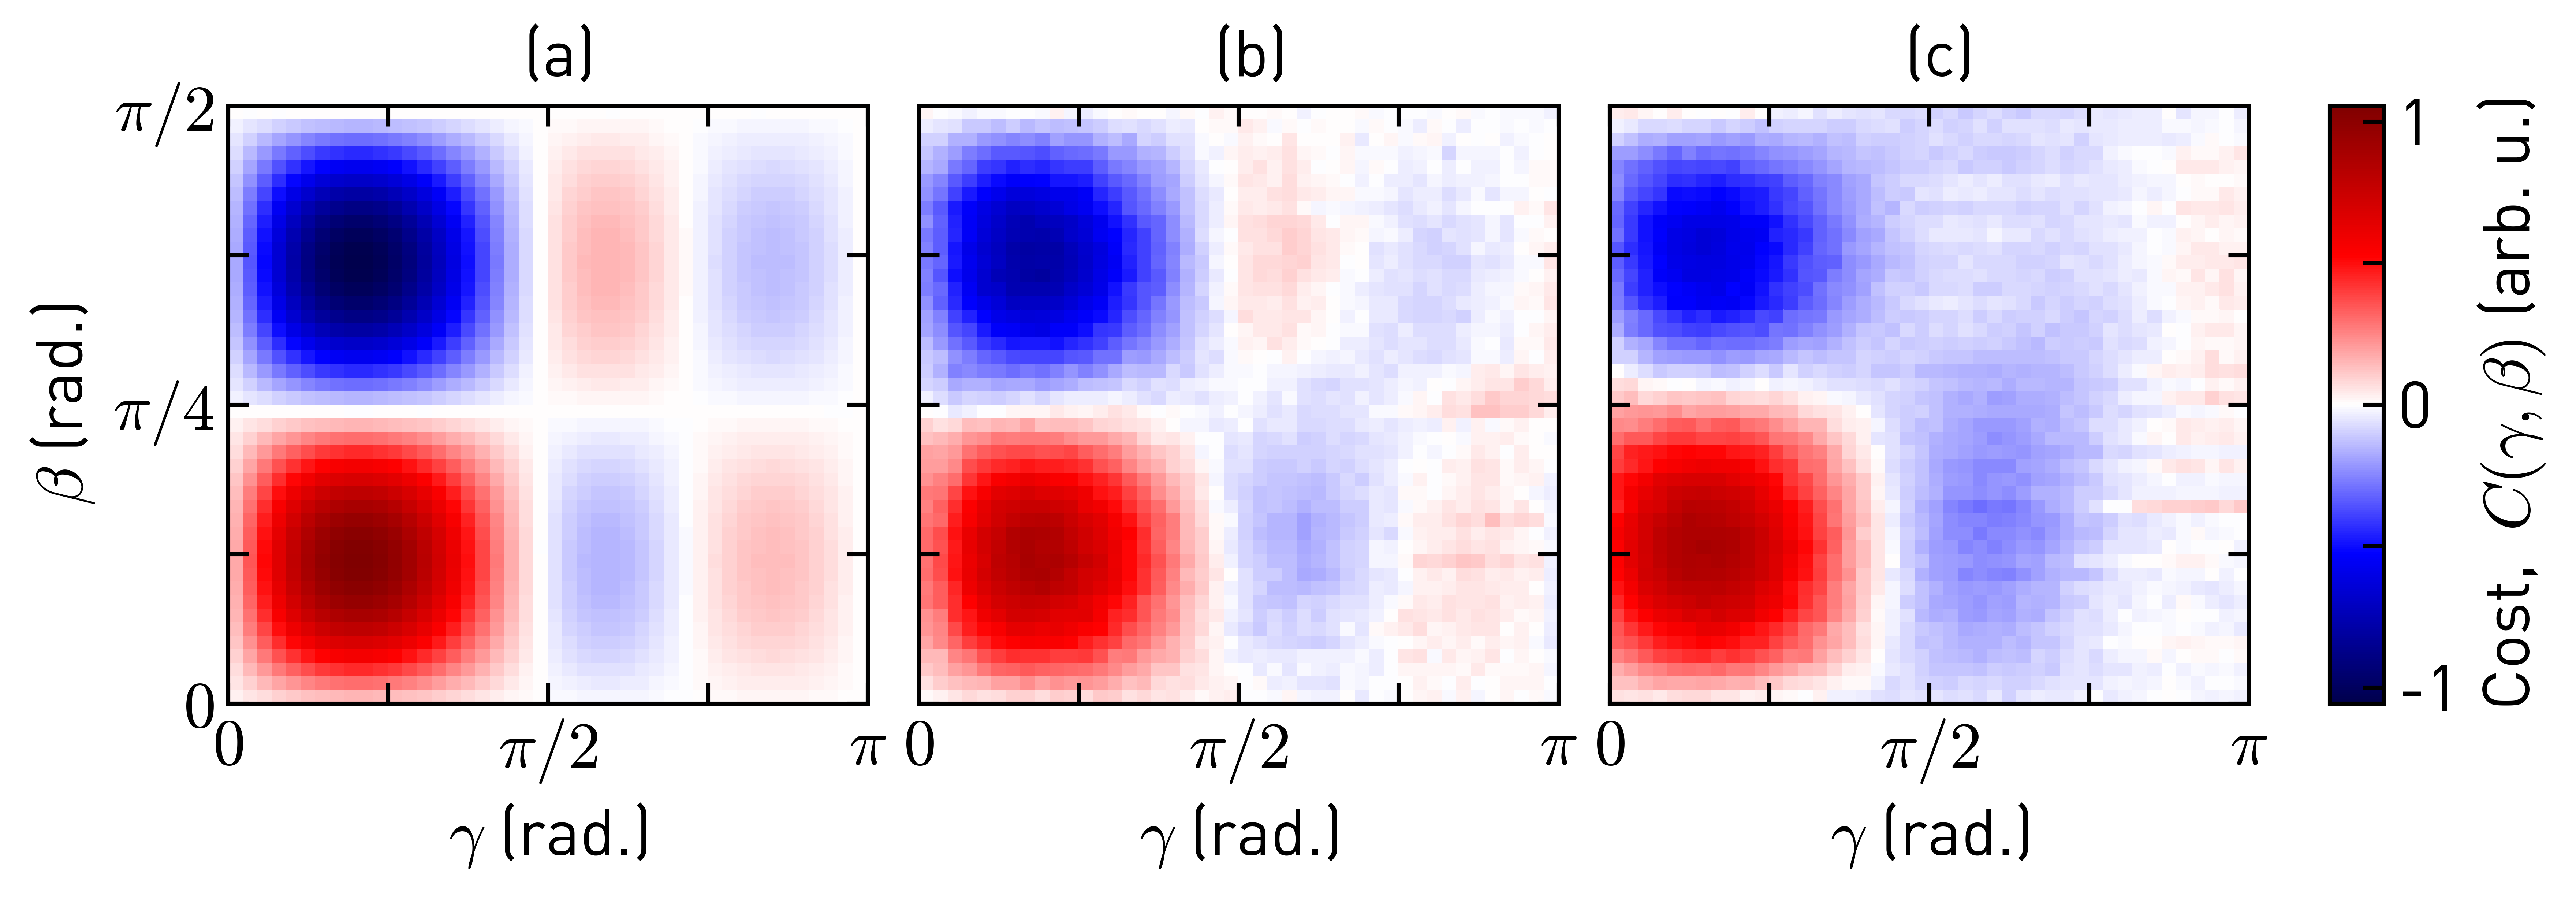

In [35]:
# plot landscapes
fig, ax = plt.subplots(ncols=3, sharey=True, 
                       figsize=(9.2,3), # vertical colorbar
#                        figsize=(9,3.5), # horizontal colorbar
                      )
cmap = "seismic"
for i, en in enumerate([energy_theory, energy_dir, energy_dec]):
    im = plot_colormesh(gg_dir*radians, bb_dir*radians, en, colorbar=False, 
                        labels=False, ax=ax[i],
#                         norm=mpl.colors.SymLogNorm(linthresh=0.05, linscale=1,
#                                               vmin=-1.5, vmax=1.5),
                   vmin=energy_theory.min(), 
                        vmax=energy_theory.max(),
                  xunits=radians, yunits=radians)
    ax[i].set_xlabel(r"$\gamma$ (rad.)")
    
### IMPORTANT NOTE: changed labels of beta to beta/2 because in fact my definition of 
# beta did not match farhi's definition of beta. This should not influence the results 
#but we should adapt the code in pycqed to have zgate(2beta) instead of zgate(beta)
plt.setp(ax, xticks=[i*np.pi/4 for i in range(5) ], 
         xticklabels=[r"$0$", r"", r"$\pi/2$", r"", r"$\pi$"], 
         yticks=[i*np.pi/8 for i in range(5) ], 
         yticklabels=[r"$0$", r"", r"$\pi/4$", r"", r"$\pi/2$"],
        )
plt.subplots_adjust(wspace=0.08)
# ax_cb = fig.add_axes([0.115,-0.03, 0.85, 0.05]) # for horizontal colorbar
ax_cb = fig.add_axes([0.88,0.2, 0.02, 0.68]) # for vertical colorbar
plt.subplots_adjust(bottom=0.2, right=0.85, left=0.1) # vertical
ax[0].set_ylabel(r"$\beta$ (rad.)")

cb = fig.colorbar(im, cax=ax_cb, ticks=[-1,-0.5,0,0.5,1],
                  label=r"Cost,  $C(\gamma, \beta)$ (arb. u.)", 
                  orientation="vertical")
cb.set_ticklabels(["-1", "", "0", "", "1"])

for a, l in zip(ax.flatten(), ["a", "b", "c"]):
    a.text(1.45, 1.65, f"({l})")

# fig.tight_layout()


In [372]:
# average leakage
print("each qubit")
[print(qbn, np.mean(l)) for qbn, l in leakages_dec.items()]
[print(qbn, np.mean(l)) for qbn, l in leakages_dir.items()]

print("Total leakage")
print(np.mean(np.sum([l for l in leakages_dec.values()], axis=0)))
print(np.mean(np.sum([l for l in leakages_dir.values()], axis=0)))

each qubit
qb1 0.045338148148148155
qb2 0.027181506172839508
qb3 0.006113604938271605
qb1 0.02778111111111111
qb2 0.013370938271604937
qb3 0.005118543209876543
Total leakage
0.07863325925925926
0.04627059259259259


In [28]:
# minimum values 
for energy, l in zip([energy_theory, energy_dir, energy_dec], ['theory', "direct", "decomposed"]):
    print(l)
    min_energy = energy.min()
    min_params = np.argmin(energy)
    print(f"Min energy: {min_energy:.3f} Params: {gg_dir.flatten()[min_params]}, {bb_dir.flatten()[min_params]}")


theory
Min energy: -1.056 Params: 0.7139983303613167, 1.1780972450961724
direct
Min energy: -0.976 Params: 0.6425984973251849, 1.1780972450961724
decomposed
Min energy: -0.843 Params: 0.6425984973251849, 1.249497078132304


In [357]:

fig.savefig(figsave_base + "qaoa_landscapes_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()), pad_inches =1, bbox='tight', bbox_extra_artists = [cb])

In [72]:
%matplotlib inline

 Text(0, 0, '0'),
 Text(0, 0, '$\\frac{\\pi}{2}$'),
 Text(0, 0, '$\\pi$'),
 Text(0, 0, '$\\frac{3\\pi}{2}$'),
 Text(0, 0, '$2\\pi$'),
 Text(0, 0, '0'),
 Text(0, 0, '$\\pi/4$'),
 Text(0, 0, '$\\pi/2$'),
 Text(0, 0, '$3\\pi/4$'),
 Text(0, 0, '$\\pi$')]

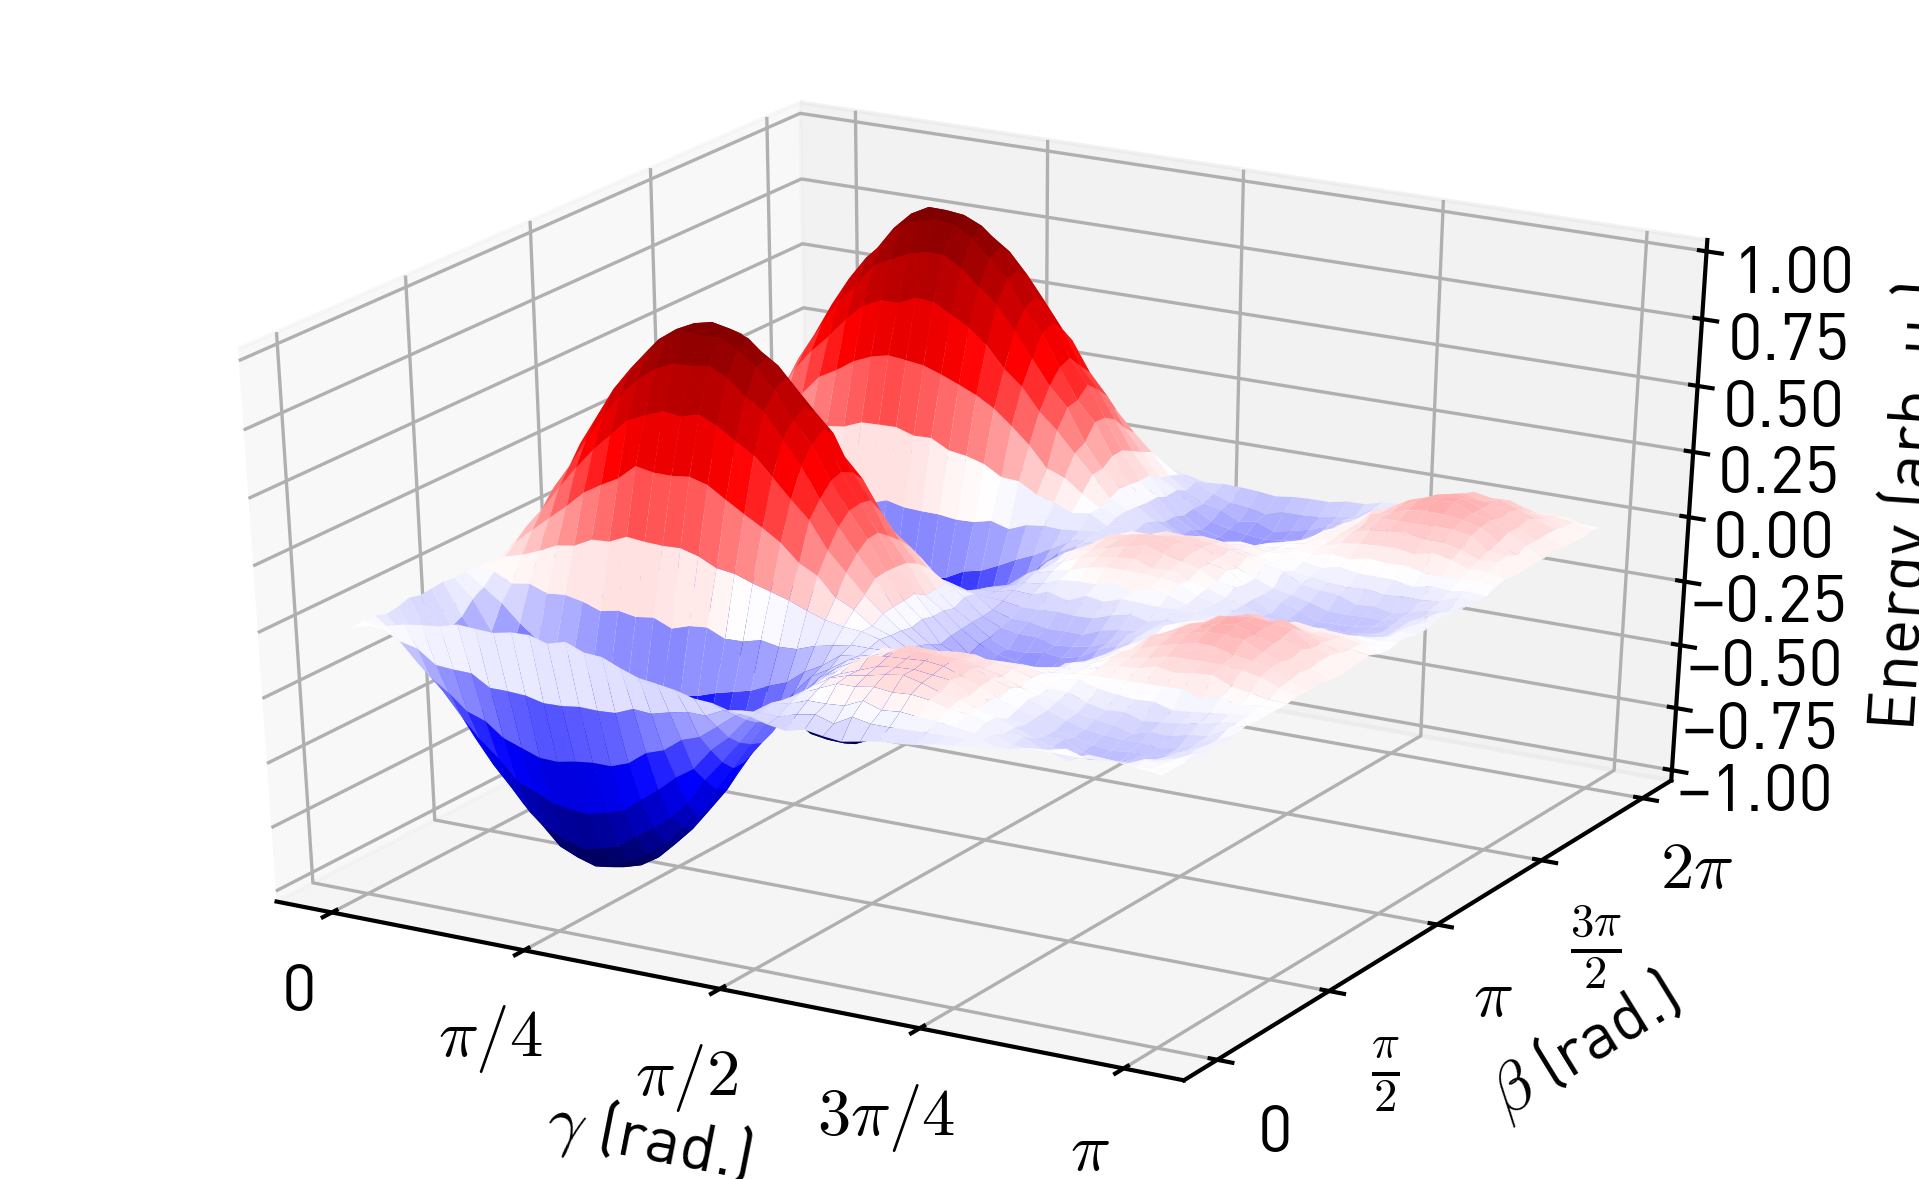

In [106]:
# plot landscape 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(g_closest, b_closest, energies +1, color= 'r', marker='o')
ax.plot_surface(gg, bb, energy_dir  , cmap="seismic", alpha=1)
# ax.plot_wireframe(gg, bb, energy_dir  , cmap="seismic", alpha=1)

ax.set_xlabel("\n $\\gamma$ (rad.)")
ax.set_ylabel("\n $\\beta$ (rad.)")
ax.set_zlim([-1,1])
ax.set_zlabel("\nEnergy (arb. u.)")

plt.setp(ax, xticks=[i*np.pi/4 for i in range(5) ], 
         xticklabels=[r"0", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"],
         yticks=[i*np.pi/2 for i in range(5) ], 
         yticklabels=[r"0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"],
        )


# Optimization Traces

In [42]:
a_tools.datadir = "X:"

## Varying p

### Traces

In [43]:
def crop_traces(traces, start=0, end=None):
    if end is None:
        end = np.amin([len(t) - 1  for t in traces])
    return [t[start:end] for t in traces]
def get_qaoa_traces(timestamps, files_per_trace=None):
    """
    Get Optimization traces of qaoa runs. 
    Args:
        timestamps (array, list): list of all timestamps
        files_per_trace (array): indicates the number of measurement files for each trace. 
            If not given tries to get it from the name of the folders.
    
    """
    if files_per_trace is None:
        fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in timestamps])
        files_per_trace = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    betas = []
    gammas = []
    iterations = []
    energies = []
    correlations = []
    iteration_masks = []
    for i, nfiles in enumerate(files_per_trace):
        print(f"Trace {i}/{len(files_per_trace)}")
        b, g, e, c, it = [],[],[],[], []
        for j in np.arange(np.sum(files_per_trace[:i]), np.sum(files_per_trace[:i]) + nfiles):
            print(timestamps[j])
            a = ma.MeasurementAnalysis(timestamp=timestamps[j], auto=False)
    #         a.get_naming_and_values()
            try:
                b.append(list(a.data_file["Experimental Data"]["Experimental Metadata"]['betas']))
                g.append(list(a.data_file["Experimental Data"]["Experimental Metadata"]['gammas']))
                it.append(a.data_file["Experimental Data"]["Experimental Metadata"].attrs['iteration'])
                e.append(a.data_file['Analysis']['Processed data']['analysis_params_dict'].attrs['energy'])
                c.append(a.data_file['Analysis']['Processed data']['correlations']['values'])
                a.data_file.close()
            except Exception as e:
                a.data_file.close()
                raise e
            

        # transform to array and compute iter mask
        b = np.asarray(b)
        g = np.asarray(g)
        it = np.asarray(it)
        e = np.asarray(e)
        c = np.asarray(c)
        iteration_mask = np.asarray([e == min(e[it == i]) 
                                   for i in range(max(it)+1)])
        iteration_mask = np.any(iteration_mask, axis=0)

        # append to global list
        betas.append(b)
        gammas.append(g)
        iterations.append(it)
        iteration_masks.append(iteration_mask)
        energies.append(e)
        correlations.append(c)
    return gammas, betas, iterations, iteration_masks,correlations,  energies

### First try (with bad IIRs and on qubits 3,1,4)

In [52]:
# load traces for direct implementation (p=1x10,2x10,3x10)
tstart_end = ["20200222_233045", "20200223_034646"] # simplex var 0.2
tps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
g_dir, b_dir, iterations_dir, iterations_masks_dir, corr_dir, energies_dir = \
    get_qaoa_traces(tps)
clear_output()

In [53]:
# load traces for decomposed implementation (p=1x15,2x15,3x15,4x15)
tstart_end = ["20200223_105830", "20200223_135903"] # simplex var 0.2
tps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
for t in ['20200223_110724']:
    tps.remove(t) # for some reason this timestamp failed
g_dec, b_dec, iterations_dec, iterations_masks_dec, corr_dec, energies_dec = \
    get_qaoa_traces(tps)
clear_output()

In [48]:
# plot properties
c_dir, c_dec = ['#3673AF', "#39B265" ]
alpha = 0.15
plot_feval = True
plot_means = True
plot_medians = False
plot_lims = (None, None) # iteration or function evaluations to plot
theory_energies = [-1.059,-1.381, -1.5, -1.5] # min reacheable with p = 1,2,3,4

Text(0, 0.5, 'Cost, $C(\\vec { \\gamma } , \\vec { \\beta })$ (arb.u.)')

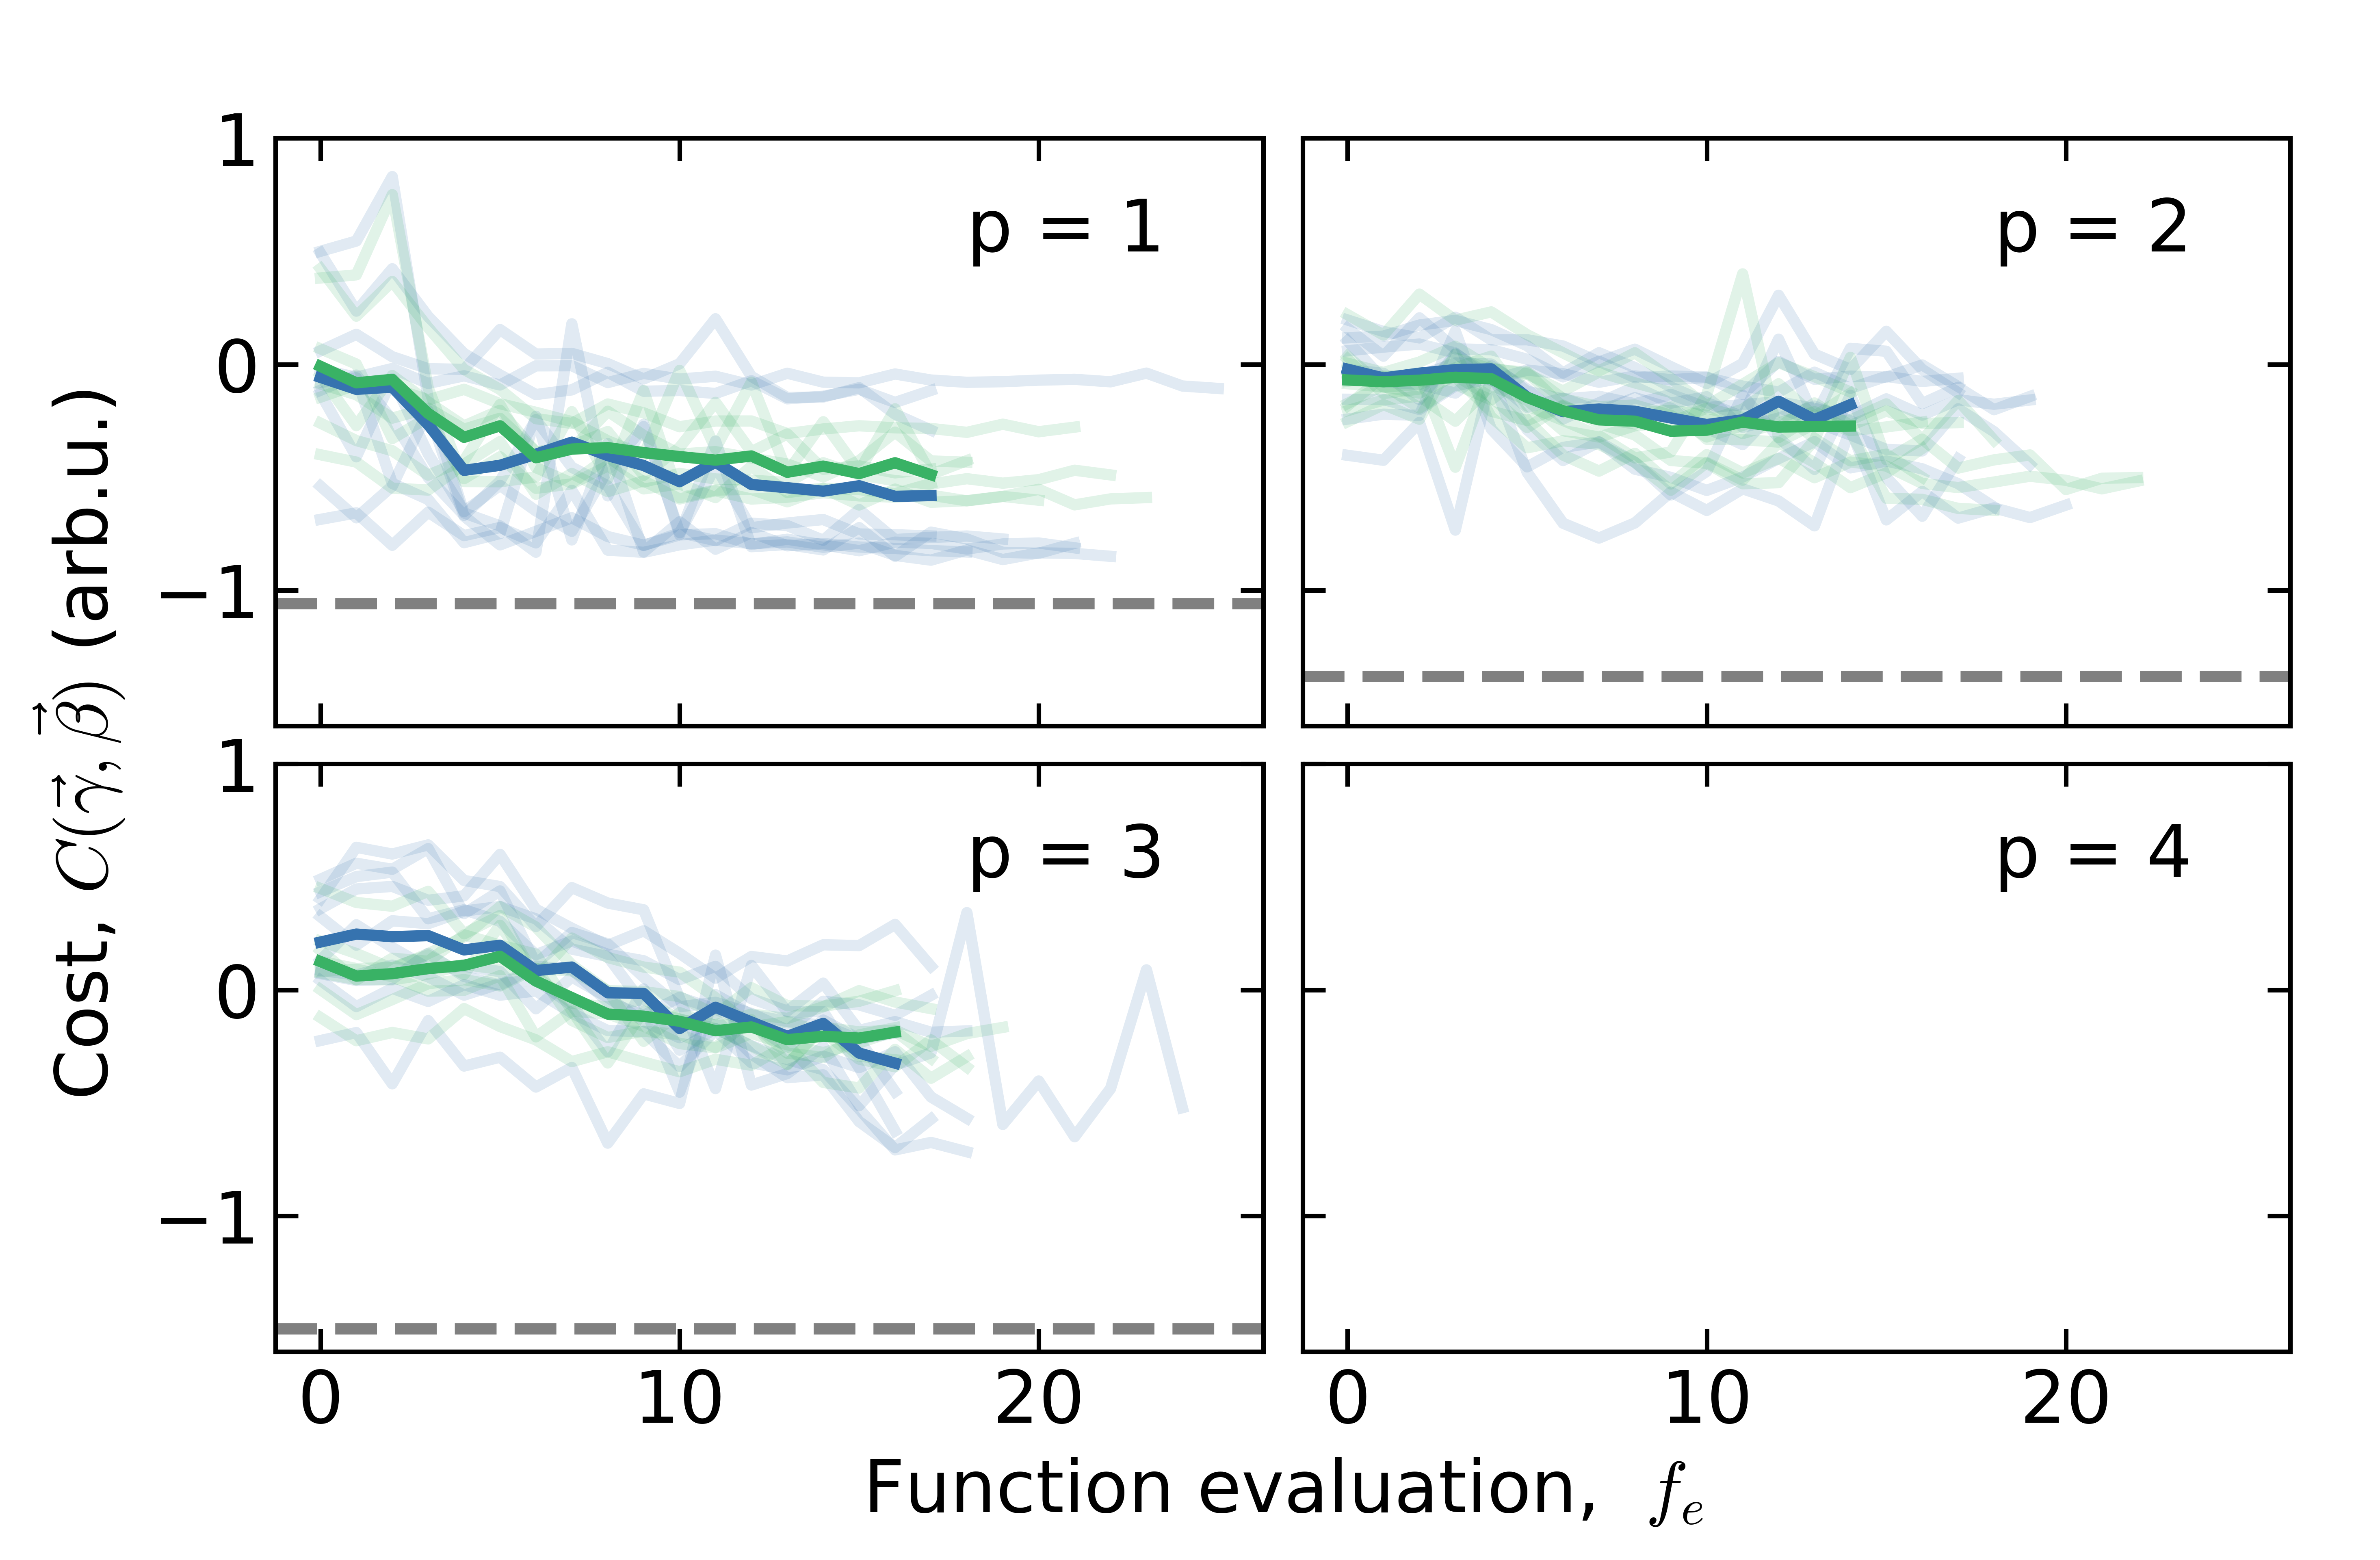

In [21]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)#, figsize=(8,6))
theory = iter(theory_energies)
# direct implentation traces
sel_dir = [(None, 9), (9, 19), (19, 29)]  # selection of traces for p = 1,2,3
color = c_dir
for (i, a), sel in zip(enumerate(ax.flatten()), sel_dir):
    for it_m, en in zip(iterations_masks_dir[sel[0]:sel[1]], 
                        energies_dir[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color, zorder=0)

    if plot_means:
        a.plot(np.mean(crop_traces(energies_dir[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=c_dir, label="Direct")

# Decomposed implementation traces

sel_dec = [(2, 10), (10, 20), (20, 28)]  # selection of traces for p = 1,2,3
color = c_dec
for a, sel in zip(ax.flatten(), sel_dec):
    for it_m, en in zip(iterations_masks_dec[sel[0]:sel[1]], 
                        energies_dec[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color,zorder=0)
    if plot_means:
        a.plot(np.mean(crop_traces(energies_dec[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=c_dec, label="Decomposed")
        
    a.axhline(next(theory), color='grey', linestyle='--', label="NF simulation")
    
for a in ax.flatten():
    a.set_ylim([-1.6,1])
#     a.legend()

# add text
for i, a in enumerate(ax.flatten()):
    a.text(18,0.5, f'p = {i + 1}')


# # add common label
plt.subplots_adjust(wspace=0.04, hspace=0.04/fig_size[1]*fig_size[0])
handles, labels = a.get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.1,0.91], ncol=3)

label_ax = fig.add_subplot(111, frameon=False)
#hide tick and tick label of the big axes
label_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel(r"Function evaluation,  $f_e$")
plt.ylabel(r"Cost, $C(\vec { \gamma } , \vec { \beta })$ (arb.u.)")


In [166]:
fig.savefig(figsave_base + "ch5_qaoa_optimization_traces_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()))

([<matplotlib.axis.YTick at 0x175b4a4be10>,
 <a list of 0 Text yticklabel objects>)

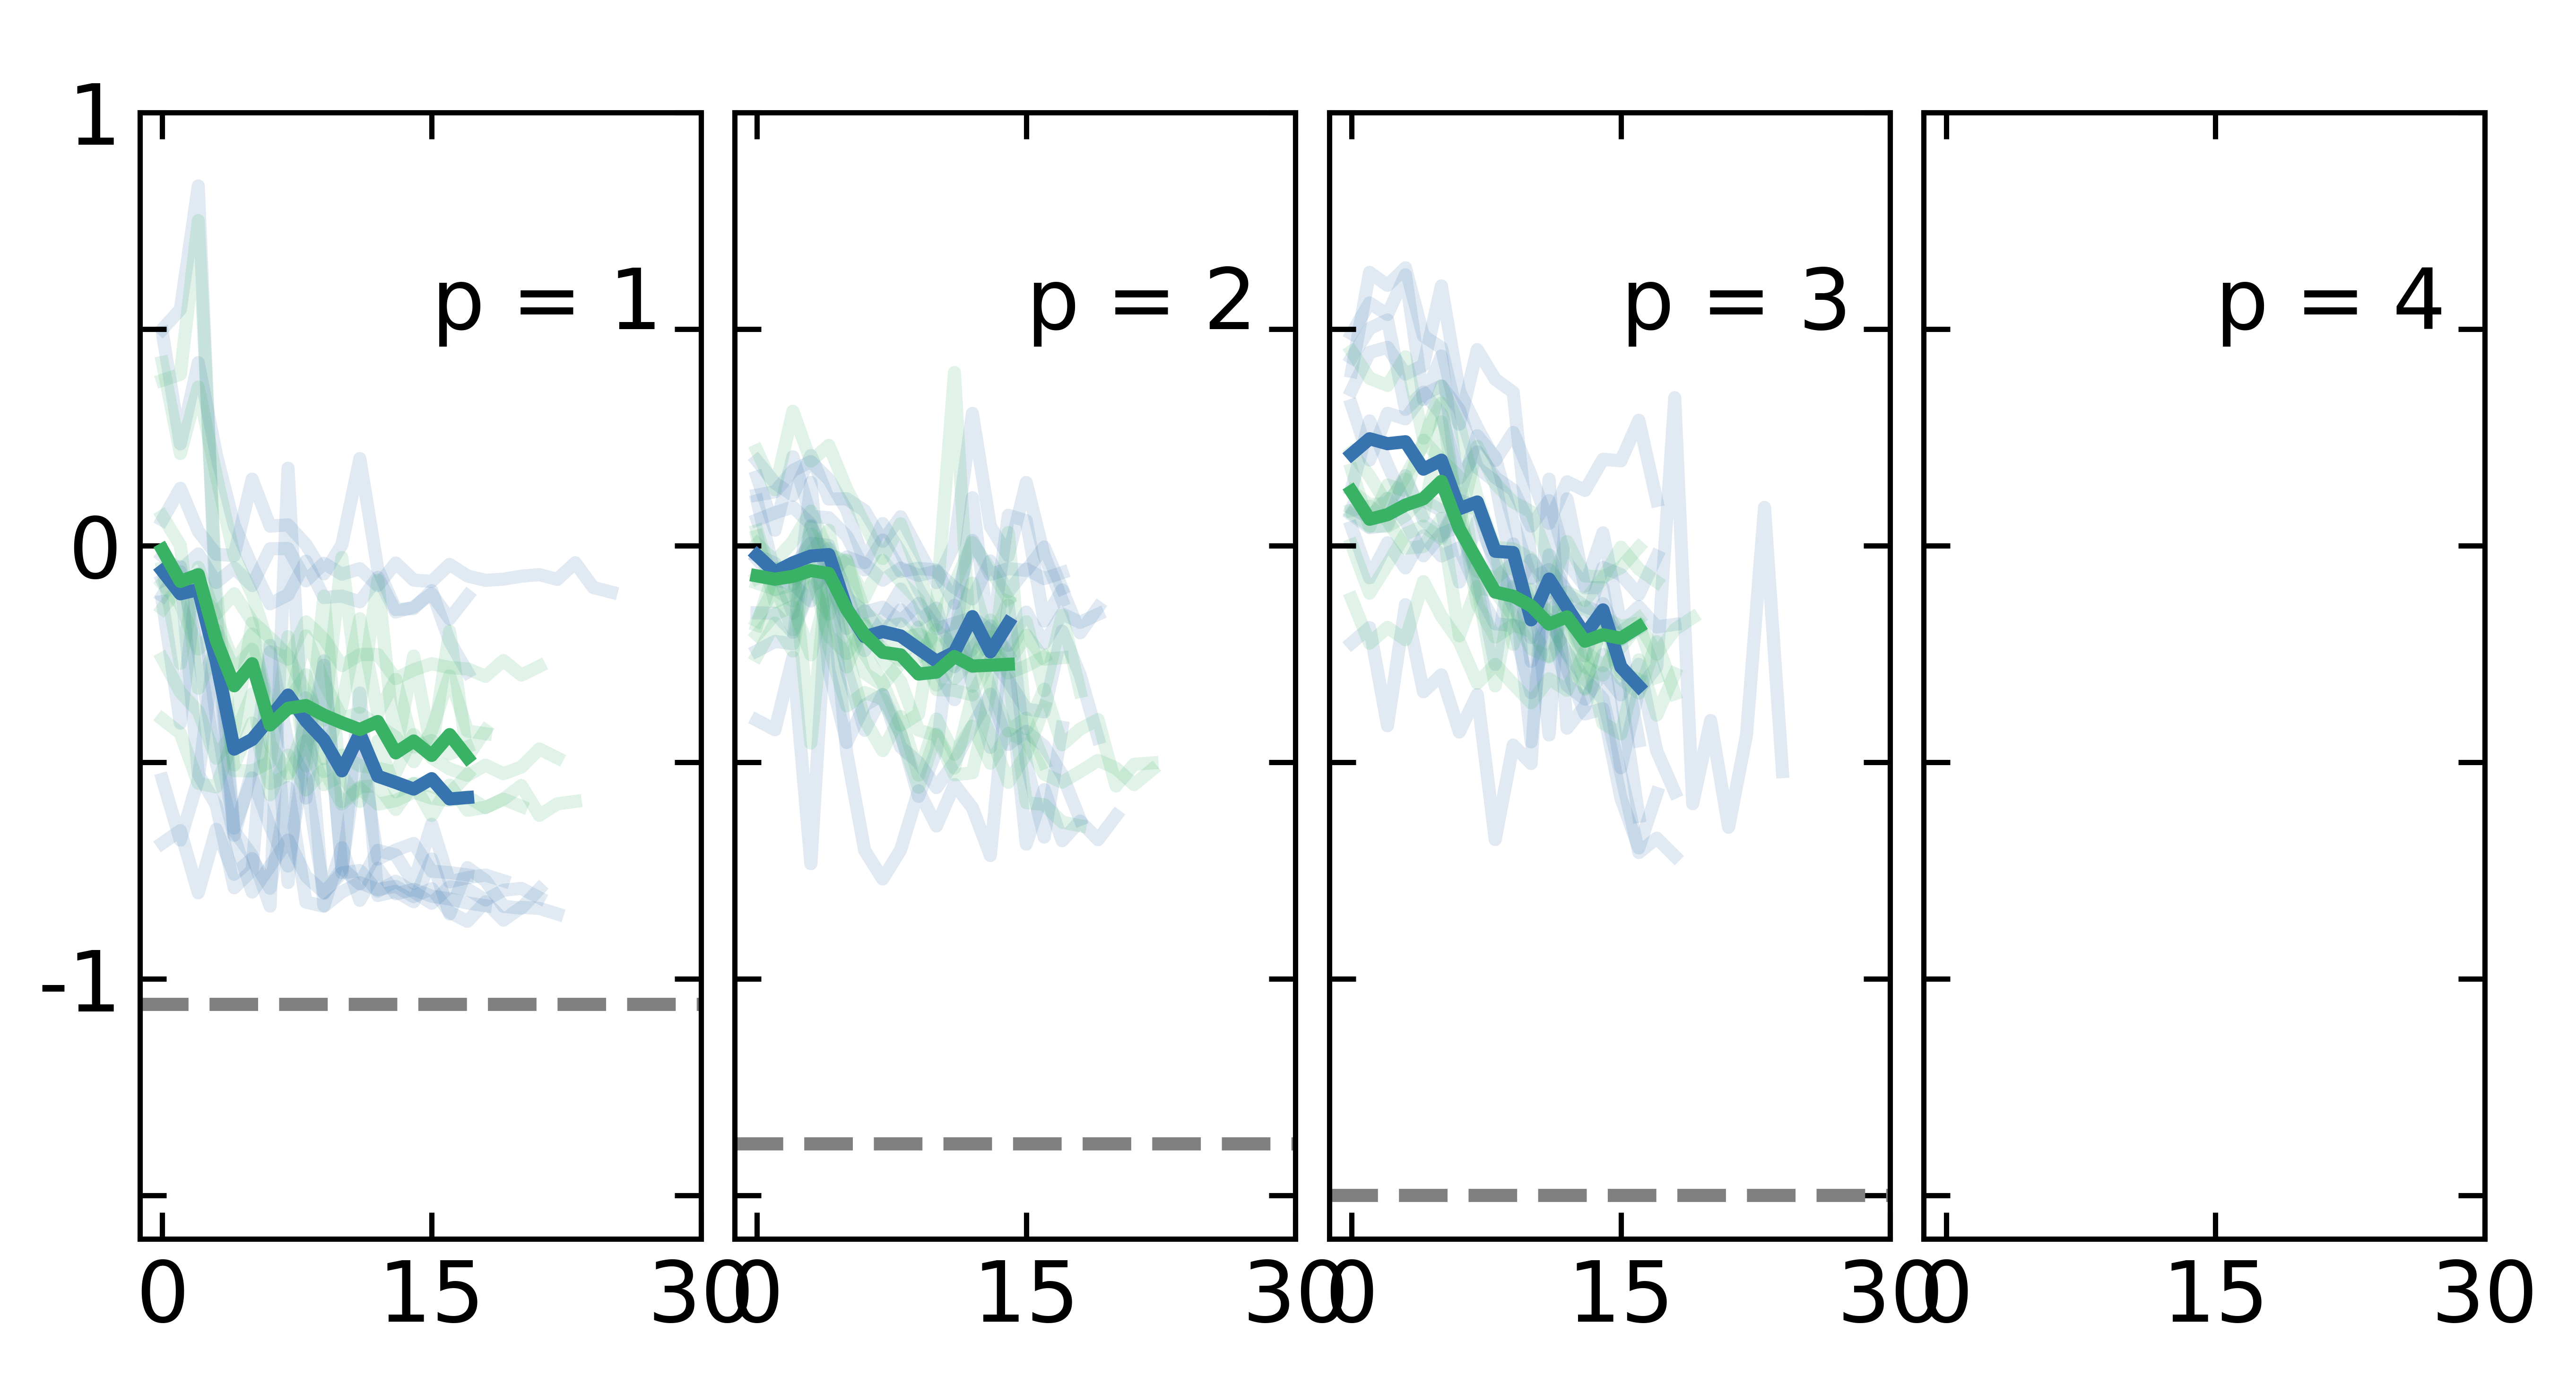

In [37]:
# variant: all subplots next to one another
plot_means = True
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,fig_size[1]-1))
theory = iter(theory_energies)
# direct implentation traces
sel_dir = [(None, 9), (9, 19), (19, 29)]  # selection of traces for p = 1,2,3
color = c_dir
for (i, a), sel in zip(enumerate(ax.flatten()), sel_dir):
    for it_m, en in zip(iterations_masks_dir[sel[0]:sel[1]], 
                        energies_dir[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color, zorder=0)

    if plot_means:
        a.plot(np.mean(crop_traces(energies_dir[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color="#3673AF", label="Direct")
    if plot_medians:
        a.plot(np.median(crop_traces(energies_dir[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color="#3673AF", label="Direct")
# Decomposed implementation traces

sel_dec = [(2, 10), (10, 20), (20, 28)]  # selection of traces for p = 1,2,3
color = c_dec
for a, sel in zip(ax.flatten(), sel_dec):
    for it_m, en in zip(iterations_masks_dec[sel[0]:sel[1]], 
                        energies_dec[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color,zorder=0)
    if plot_means:
        a.plot(np.mean(crop_traces(energies_dec[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color="#39B265", label="Decomposed")
    if plot_medians:
        a.plot(np.median(crop_traces(energies_dec[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color="#39B265", label="Direct")
    a.axhline(next(theory), color='grey', linestyle='--', label="NF simulation")
    
for a in ax.flatten():
    a.set_ylim([-1.6,1.0])
#     a.legend()

# add text
for i, a in enumerate(ax.flatten()):
    a.text(15,0.5, f'p = {i + 1}')
    a.set_xticks([0, 15, 30])

# add common label
plt.subplots_adjust(wspace=0.06, hspace=0.04)
handles, labels = a.get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.12,0.885], ncol=3)
plt.yticks([-1.5, -1,-0.5,0,0.5, 1], ["", -1,"",0,"", 1])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel(r"Function evaluation,  $f_e$")
plt.ylabel(r"Cost, $C(\vec { \gamma } , \vec { \beta })$ (arb.u.)")


In [290]:
fig.savefig(figsave_base + "ch5_qaoa_optimization_traces_one_line_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()))

### Second try: qubits 1,4,2 and new IIRs

In [ ]:
# load traces for direct implementation (p=1x10,2x10,3x10)
# tstart_end = ["20200222_233045", "20200223_034646"] # simplex var 0.2
# tps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
# g_dir, b_dir, iterations_dir, iterations_masks_dir, corr_dir, energies_dir = \
#     get_qaoa_traces(tps)
# clear_output()

In [45]:
# load traces for direct implementation (p=1x10,2x10,3x10)
tstart_end = ["20200229_173650", "20200301_031938"]# removed last two traces because of damned analysis not existing WHYYYYY?
tps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
g_dir2, b_dir2, iterations_dir2, iterations_masks_dir2, corr_dir2, energies_dir2 = \
    get_qaoa_traces(tps)
clear_output()

In [46]:
# load traces for decomposed implementation (p=1x15,2x15,3x15,4x15)
tstart_end = ["20200227_214004", "20200228_045406"] # removed last two traces because of damned analysis not existing WHYYYYY?
tps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
g_dec2, b_dec2, iterations_dec2, iterations_masks_dec2, corr_dec2, energies_dec2 = \
    get_qaoa_traces(tps)
clear_output()

Text(0, 0.5, 'Cost, $C(\\vec { \\gamma } , \\vec { \\beta })$ (arb.u.)')

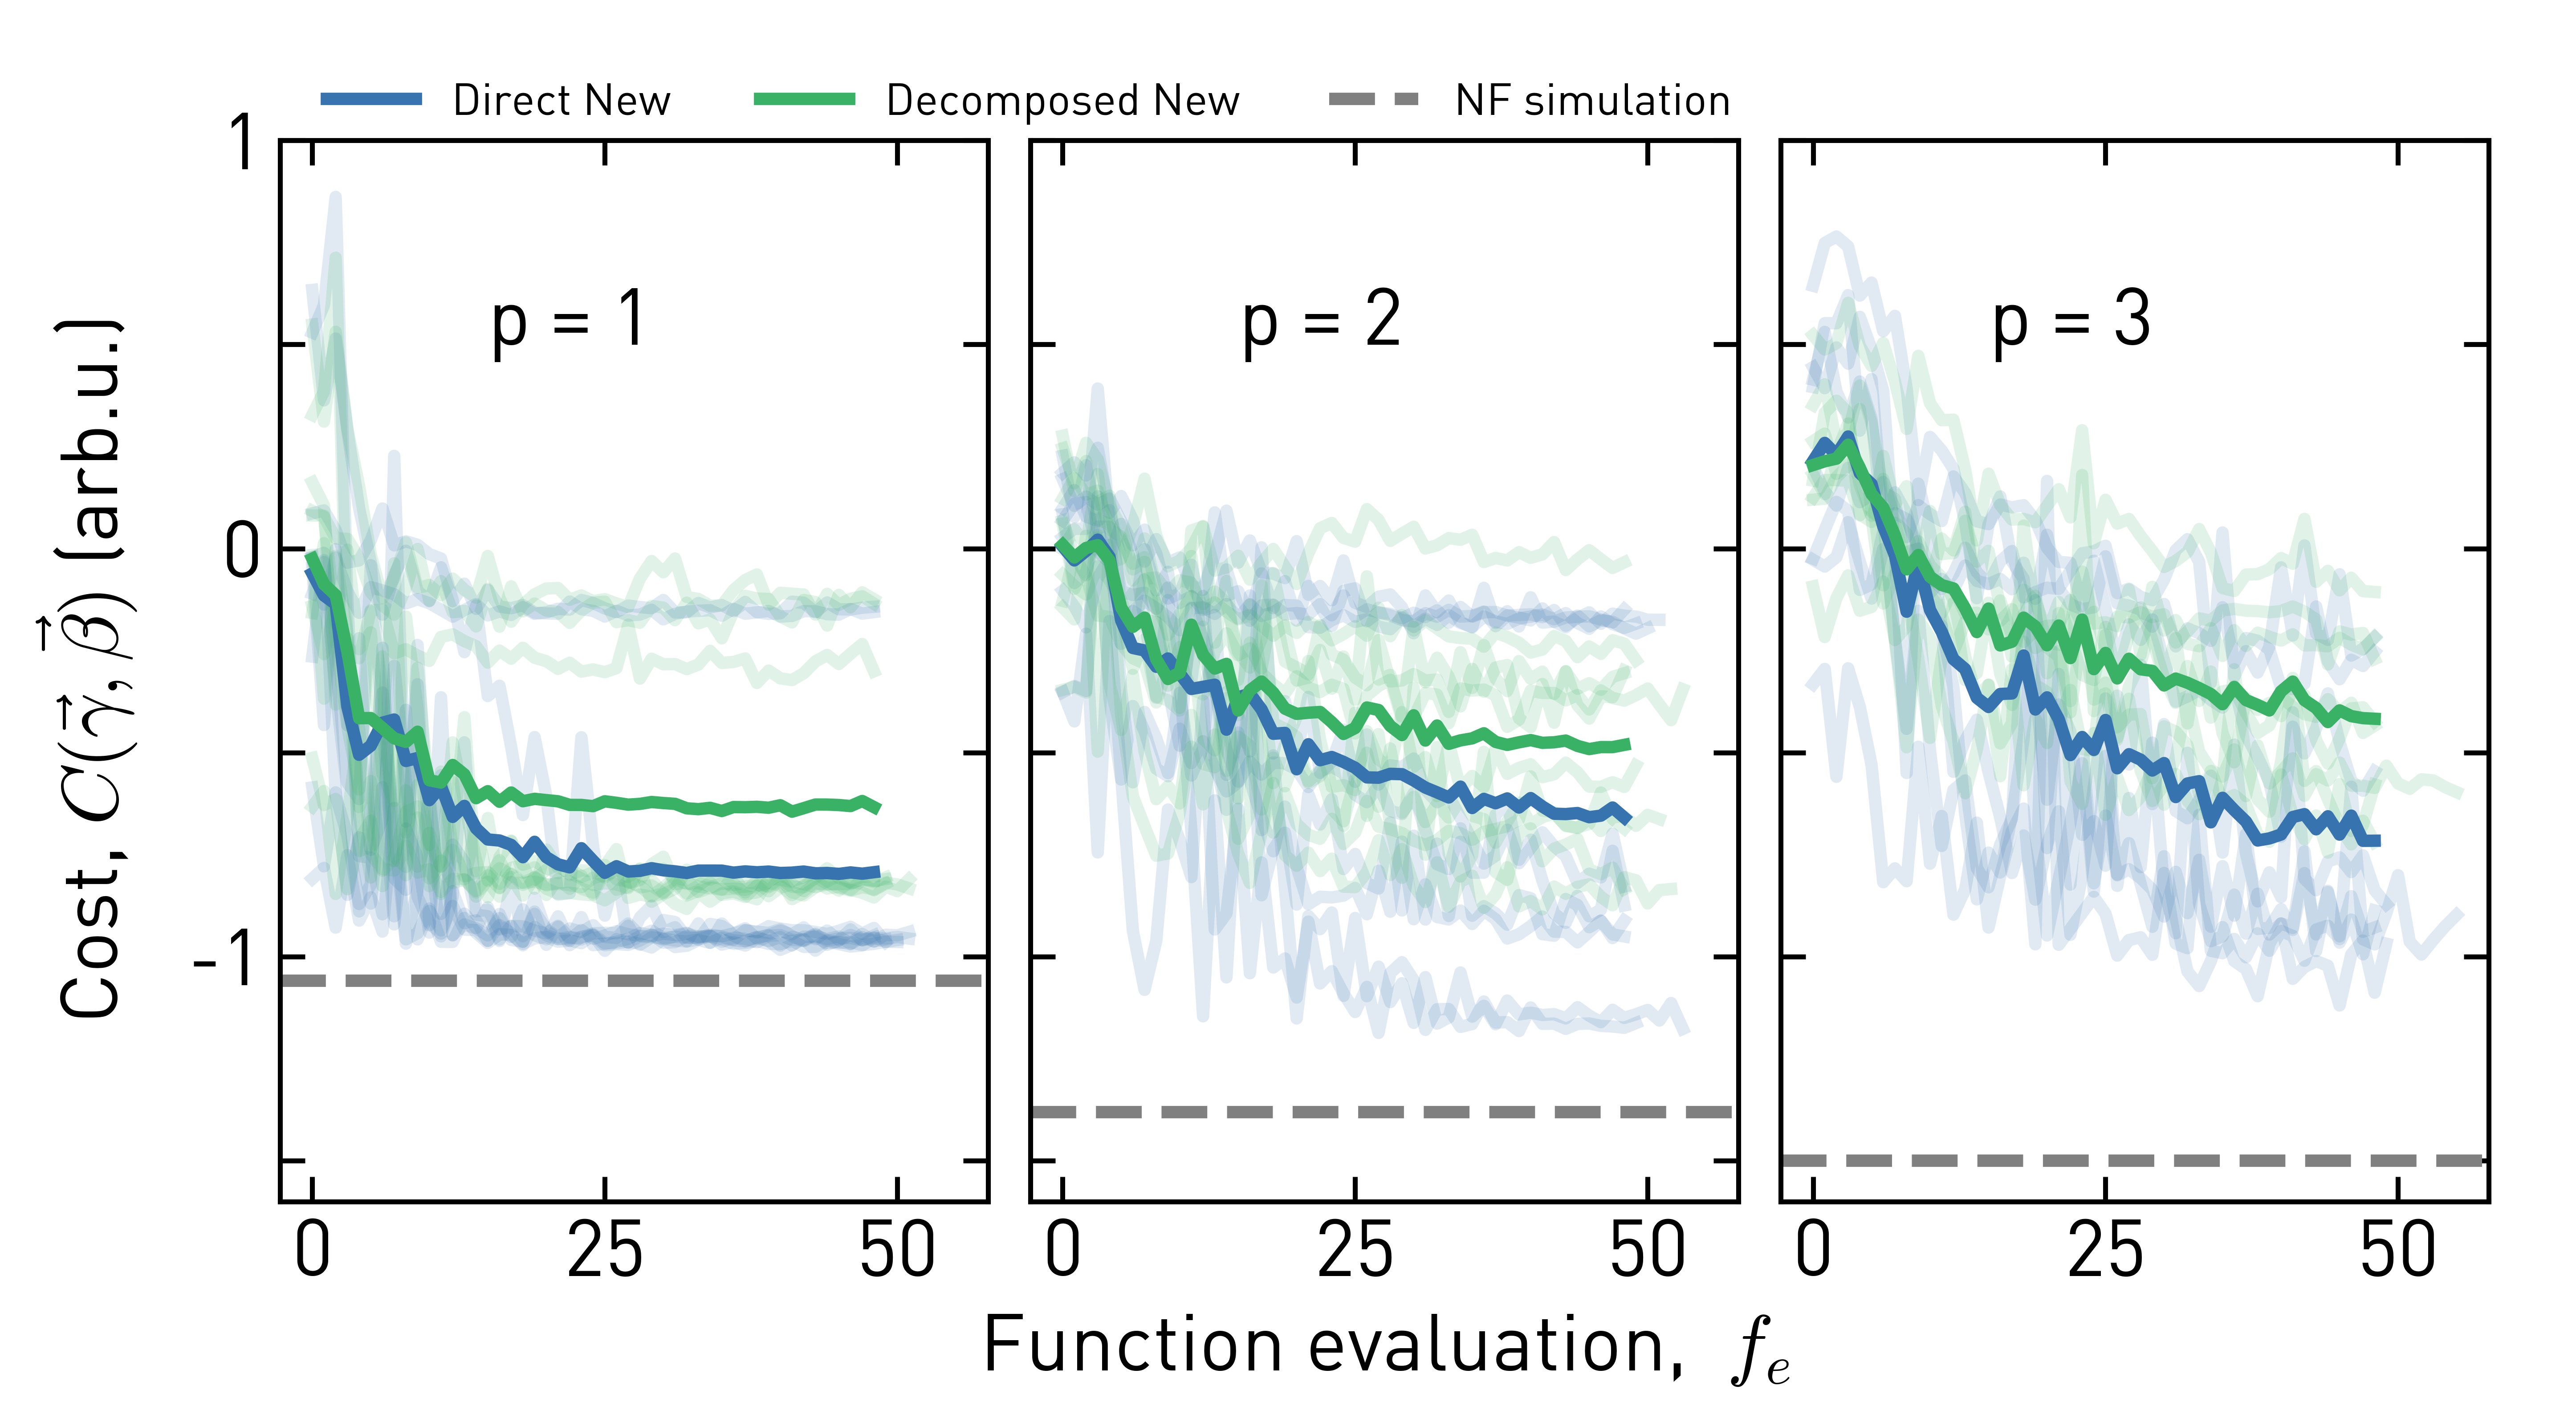

In [56]:
# variant: all subplots next to one another
plot_means = True
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(8,fig_size[1]-1))
theory = iter(theory_energies)

# direct new version
sel_dir2 = [(None, 10), (10, 20), (20, 28)]  # selection of traces for p = 1,2,3
color = c_dir #"#734687"
for a, sel in zip(ax.flatten(), sel_dir2):
    for it_m, en in zip(iterations_masks_dir2[sel[0]:sel[1]], 
                        energies_dir2[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color,zorder=0)
    if plot_means:
        a.plot(np.mean(crop_traces(energies_dir2[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=color, label="Direct New")
    if plot_medians:
        a.plot(np.median(crop_traces(energies_dir2[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=color, label="Direct New")
        
# decomposed new version
sel_dec2 = [(None, 10), (10, 20), (20, 28)]  # selection of traces for p = 1,2,3
color = c_dec #'#873D48' # "#734687"
for a, sel in zip(ax.flatten(), sel_dec2):
    for it_m, en in zip(iterations_masks_dec2[sel[0]:sel[1]], 
                        energies_dec2[sel[0]:sel[1]]):
        en = crop_traces([en], *plot_lims)[0]
        if plot_feval:
            a.plot(en, alpha=alpha, color=color, zorder=0)
        else:
            a.plot(en[it_m], alpha=alpha, color=color,zorder=0)
    if plot_means:
        a.plot(np.mean(crop_traces(energies_dec2[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=color, label="Decomposed New")
    if plot_medians:
        a.plot(np.median(crop_traces(energies_dec2[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
               color=color, label="Decomposed New")
    a.axhline(next(theory), color='grey', linestyle='--', label="NF simulation")

# direct implentation traces
# sel_dir = [(None, 9), (9, 19), (19, 29)]  # selection of traces for p = 1,2,3
# color = c_dir
# for (i, a), sel in zip(enumerate(ax.flatten()), sel_dir):
#     for it_m, en in zip(iterations_masks_dir[sel[0]:sel[1]], 
#                         energies_dir[sel[0]:sel[1]]):
#         en = crop_traces([en], *plot_lims)[0]
#         if plot_feval:
#             a.plot(en, alpha=alpha, color=color, zorder=0)
#         else:
#             a.plot(en[it_m], alpha=alpha, color=color, zorder=0)

#     if plot_means:
#         a.plot(np.mean(crop_traces(energies_dir[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
#                color="#3673AF", label="Direct")
#     if plot_medians:
#         a.plot(np.median(crop_traces(energies_dir[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
#                color="#3673AF", label="Direct")

# # Decomposed implementation traces
# sel_dec = [(2, 10), (10, 20), (20, 28)]  # selection of traces for p = 1,2,3
# color = c_dec
# for a, sel in zip(ax.flatten(), sel_dec):
#     for it_m, en in zip(iterations_masks_dec[sel[0]:sel[1]], 
#                         energies_dec[sel[0]:sel[1]]):
#         en = crop_traces([en], *plot_lims)[0]
#         if plot_feval:
#             a.plot(en, alpha=alpha, color=color, zorder=0)
#         else:
#             a.plot(en[it_m], alpha=alpha, color=color,zorder=0)
#     if plot_means:
#         a.plot(np.mean(crop_traces(energies_dec[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
#                color=c_dec, label="Decomposed")
#     if plot_medians:
#         a.plot(np.median(crop_traces(energies_dec[sel[0]:sel[1]], *plot_lims), axis=0), alpha=1, 
#                color=c_dec, label="Direct")



for a in ax.flatten():
    a.set_ylim([-1.6,1.0])
#     a.legend()

# add text
for i, a in enumerate(ax.flatten()):
    a.text(15,0.5, f'p = {i + 1}')
    a.set_xticks([0, 25, 50])

# add common label
plt.subplots_adjust(wspace=0.06, hspace=0.04)
handles, labels = a.get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.12,0.9], ncol=4, prop={'size':9})
plt.yticks([-1.5, -1,-0.5,0,0.5, 1], ["", -1,"",0,"", 1])

labelax = fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
labelax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
plt.xlabel(r"Function evaluation,  $f_e$")
plt.ylabel(r"Cost, $C(\vec { \gamma } , \vec { \beta })$ (arb.u.)")

# Success prob versus depth

In [26]:
def get_end_results_from_traces(correct_states, 
                              tstart_end=None, timestamps=None, files_per_trace=None,
                             plot=False):
    
    if (timestamps, tstart_end) is (None, None):
        raise ValueError()
    if tstart_end is not None:
        timestamps = a_tools.get_timestamps_in_range(tstart_end[0], tstart_end[1], label="QAOA")
    if files_per_trace is None:
        fevals = np.array([eval(a_tools.get_folder(t).split("_")[-1]) for t in timestamps])
        files_per_trace = -np.diff(np.pad(fevals, (0,1), 'constant'))[np.diff(np.pad(fevals, (0,1), 'constant')) != 1] + 1
    
    results = []
    for t in np.array(timestamps)[np.cumsum(files_per_trace).astype(int) - 1]:
        print(t)
        results.append(bar_plot(t, plot=plot, correct_states=correct_states))
    return results        

## load measurements

In [67]:
# load success prob from traces direct implementation
tstart_end = ["20191202_001439", "20191202_162002"]
correct_states = ["[0 1 0]", "[1 0 1]"]
traces_results_dir = get_end_results_from_traces(correct_states, tstart_end=tstart_end)

# get success prob per depth from results
depths_traces = np.unique([r['depth'] for r in traces_results_dir])
success_probs_traces_start_dir = \
    [[r["success_prob"] for r in traces_results_dir if r['depth'] == d]
                                  for d in depths_traces]
clear_output()

In [68]:
# load success prob from traces decomposed implementation
tstart_end = ["20191206_151020", "20191207_093239"]
correct_states = ["[0 1 0]", "[1 0 1]"]
traces_results_dec = get_end_results_from_traces(correct_states, tstart_end=tstart_end)

# get success prob per depth from results
depths_traces = np.unique([r['depth'] for r in traces_results_dec])
success_probs_traces_start_dec = \
    [[r["success_prob"] for r in traces_results_dec if r['depth'] == d]
                                  for d in depths_traces]
clear_output()

In [69]:
# load success prob near optimal param computed classically for direct
# one to 5
t_start = "20191203_191009"
t_end = "20191203_195510"
params_1_5_dir = get_parameters_runs(t_start, t_end)
reps_per_p = 1
n_depths = 5
timestamps = []
depths= []
res_opt_start_dir = []
success_probs_opt_start_dir = []

for i in range(n_depths):
    min_energy = np.inf
    t = None
    for _ in range(reps_per_p):
        for p in params_1_5_dir[i*reps_per_p:(i+1)*reps_per_p]:
            # get timestamp with min energy
            if np.amin(p["energy"]) < min_energy:
                min_energy =np.amin(p["energy"])
                t = p["timestamps"][np.argmin(p['energy'])]
    res = bar_plot(t, save=False, correct_states=correct_states, plot=False)
    res_opt_start_dir.append(res)
    depths.append(res["depth"])
    success_probs_opt_start_dir.append(res['success_prob'])

# start at depth = 6 up to 10
t_start = "20191203_173542"
t_end = "20191203_185307"
params_6_10_dir = get_parameters_runs(t_start, t_end)
reps_per_p = 1
n_depths = 5
for i in range(n_depths):
    min_energy = np.inf
    t = None
    for _ in range(reps_per_p):
        for p in params_6_10_dir[i*reps_per_p:(i+1)*reps_per_p]:
            # get timestamp with min energy
            if np.amin(p["energy"]) < min_energy:
                min_energy =np.amin(p["energy"])
                t = p["timestamps"][np.argmin(p['energy'])]
    res = bar_plot(t, save=False, correct_states=correct_states, plot=False)
    res_opt_start_dir.append(res)
    depths.append(res["depth"])
    success_probs_opt_start_dir.append(res['success_prob'])
clear_output()

In [70]:
# load success prob near optimal param computed classically for decomposed

t_start = "20191206_135126"
t_end = "20191206_150548"
params_dec = get_parameters_runs(t_start, t_end)
reps_per_p = 1
n_depths = 10
timestamps = []
depths = []
success_probs_opt_start_dec = []
res_opt_start_dec = []
for i in range(n_depths):
    min_energy = np.inf
    t = None
    for _ in range(reps_per_p):
        for p in params_dec[i*reps_per_p:(i+1)*reps_per_p]:
            # get timestamp with min energy
            if np.amin(p["energy"]) < min_energy:
                min_energy =np.amin(p["energy"])
                t = p["timestamps"][np.argmin(p['energy'])]
    res = bar_plot(t, save=False, correct_states=correct_states, plot=False)
    depths.append(res["depth"])
    res_opt_start_dec.append(res)
    success_probs_opt_start_dec.append(res['success_prob'])
clear_output()

## Load theory

In [71]:
# load theory
qbs = [0,1,2]
n_qbs = len(qbs)
two_qb_pairs = [(i,j) for i,j in zip(qbs, qbs[1:])] # linear array
hs = [0,0,0]
Cs = [0.5, 1]
optimal_params={
    1:dict(g=[0.67848787], b=[3.9269908]),
    2: dict(g=[0.64186931,1.15633934], b=[1.08778431,0.56831448]),
    3: dict(g=[ 0.91293813,  1.38149213,  2.64575812], b=[4.25592023,  6.8627972,  -0.47658777]),
    4: dict(g= [0.79047109, 1.29788154, 2.65529822, 1.02307546 ], b=[ 0.9663438, 3.66163585, 5.75941282 ,6.01503621]),
    5: dict(g = [0.62732382, 0.00640932, 1.21334409, 0.32948633, 1.03519245], b=[0.21928593 ,1.03185706, 0.84183517, 3.16511823, 3.56522479] ),
    6: dict(g=[1.03885048, 1.35146962, 2.06623968, 2.43631484, 3.12286653, 2.84845525], 
            b=[5.16561146, 4.02608211, 5.61752595, 6.82999765, 0.340696,   0.93796757]),
    7: dict(g=[ 1.13027127,  2.39374872, -0.35931365,  3.47810144,  1.62313939 , 0.16434764, 0.75164923], b=[  1.60770037,  2.89058529 , 1.63604546 , 1.33216744 , 1.46064182, 5.68443475,  3.85156408] ),
    8: dict(g=[1.055365503442032,1.3098777325119684,1.7014313196688995,1.147763909186312,0.6952683724838693,2.4871574459657615,2.162997348460366,2.368623128268789], b=[6.700351002594094,2.750288054308348,1.8334785312398794,1.4997245667843095,3.973993966376086,3.124898728718041,5.88391836689478,5.80487108919712]),
    9: dict(g=[2.255384671867681,1.1263556452930128,2.3564798544033287,0.4540511845994959,0.45683699857291366,0.42311647779005124,2.6114716195550667,0.7300887629608801,1.9252202179959783], b=[4.099035024586171,1.1189046530120206,2.6440433383427684,0.3914697152007607,3.797694667114474,0.47789898540596154,4.662660755443585,2.370377288094952,2.4849199081896343]),
    10:dict(g=[1.940897768208033,0.9666844823356445,2.772132044860666,2.309917454663161,3.3445826894178183,1.1224922614360544,2.5426242774323127,3.4136236280179553,-0.16948225188854313,1.9267825683628026], b=[1.77851179850078,2.2033574267981217,1.4819516119903635,4.480386169071666,2.495939695232518,0.07321215272329895,6.294539837569337,2.3051562674962494,2.244969010609862,5.373081388770109])}
success_prob_opt_nf_sim = []
state_prob_opt_nf_sim = []
for p in optimal_params.values():
    gammas, betas = p['g'], p['b']
    U = qaoa_propagator(n_qbs, two_qb_pairs, gammas, betas, Cs, hs)
    H = U * ket("0"*n_qbs)
    expected_state= np.real((H*H.dag()).full()[np.eye(len(H.full()), dtype=bool)])
    expected_state_labels = np.array(cs_to_phys(list(itertools.product((0,1), repeat=n_qbs))))
    if correct_states is not None:
        success_prob_theory = np.sum([expected_state[expected_state_labels == c] 
                                      for c in cs_to_phys(correct_states)])
        success_prob_opt_nf_sim.append(success_prob_theory)
    state_prob_opt_nf_sim.append(expected_state)

## Load Sequence lengths

In [21]:
from pycqed.measurement import qaoa
from pycqed.measurement import multi_qubit_module as mqm
import pycqed.measurement.waveform_control.segment as segment
import pycqed.utilities.general as gen
from importlib import reload
reload(segment)

"UHFQuantumController" not imported.


<module 'pycqed.measurement.waveform_control.segment' from 'c:\\users\\nathan\\masterthesis\\code\\controlsoftware\\pycqed_py3\\pycqed\\measurement\\waveform_control\\segment.py'>

**Sequence lengths from 0 until first data point of readout pulse**

In [72]:
# direct implementation
# from ressources/qaoa lengths.ipynb
lengths_dir = \
[0.38222222222222224,
 0.711111111111111,
 1.0,
 1.3511111111111112,
 1.5777777777777777,
 1.8533333333333333,
 2.222222222222222,
 2.6844444444444444,
 2.9955555555555553,
 3.1511111111111108]

In [73]:
# sequence length worst case direct (only pi two qb gates)
lengths_dir_worst_case = [0.3955555555555555,
 0.7422222222222221,
 1.0933333333333335,
 1.4444444444444442,
 1.7955555555555553,
 2.142222222222222,
 2.493333333333333,
 2.844444444444444,
 3.191111111111111,
 3.542222222222222]

In [74]:
# sequence length decomposed
# from ressources/qaoa lengths.ipynb
lengths_dec = \
[1.0222222222222221,
 2.0,
 2.982222222222222,
 3.9600000000000004,
 4.937777777777778,
 5.915555555555555,
 6.8933333333333335,
 7.875555555555556,
 8.853333333333332,
 9.83111111111111]


## Prepare plot and plot

In [75]:
# prepare plot
crop = 9


In [309]:
# me = [0.5583162519402016,
#  0.7298898176065779,
#  0.5628211340936882,
#  0.5549802287641488,
#  0.28315563510471575,
#  0.15616239926193265,
#  0.3278036037560843,
#  0.372550089513358,
#  0.3607973665952706]

# no alpha zz
me = [0.5895279281716093,
 0.7709312924554252,
 0.8011564042064074,
 0.7493480880858692,
 0.7232543402264557,
 0.6617557212963893,
 0.6603480932624091,
 0.5861468773322062]

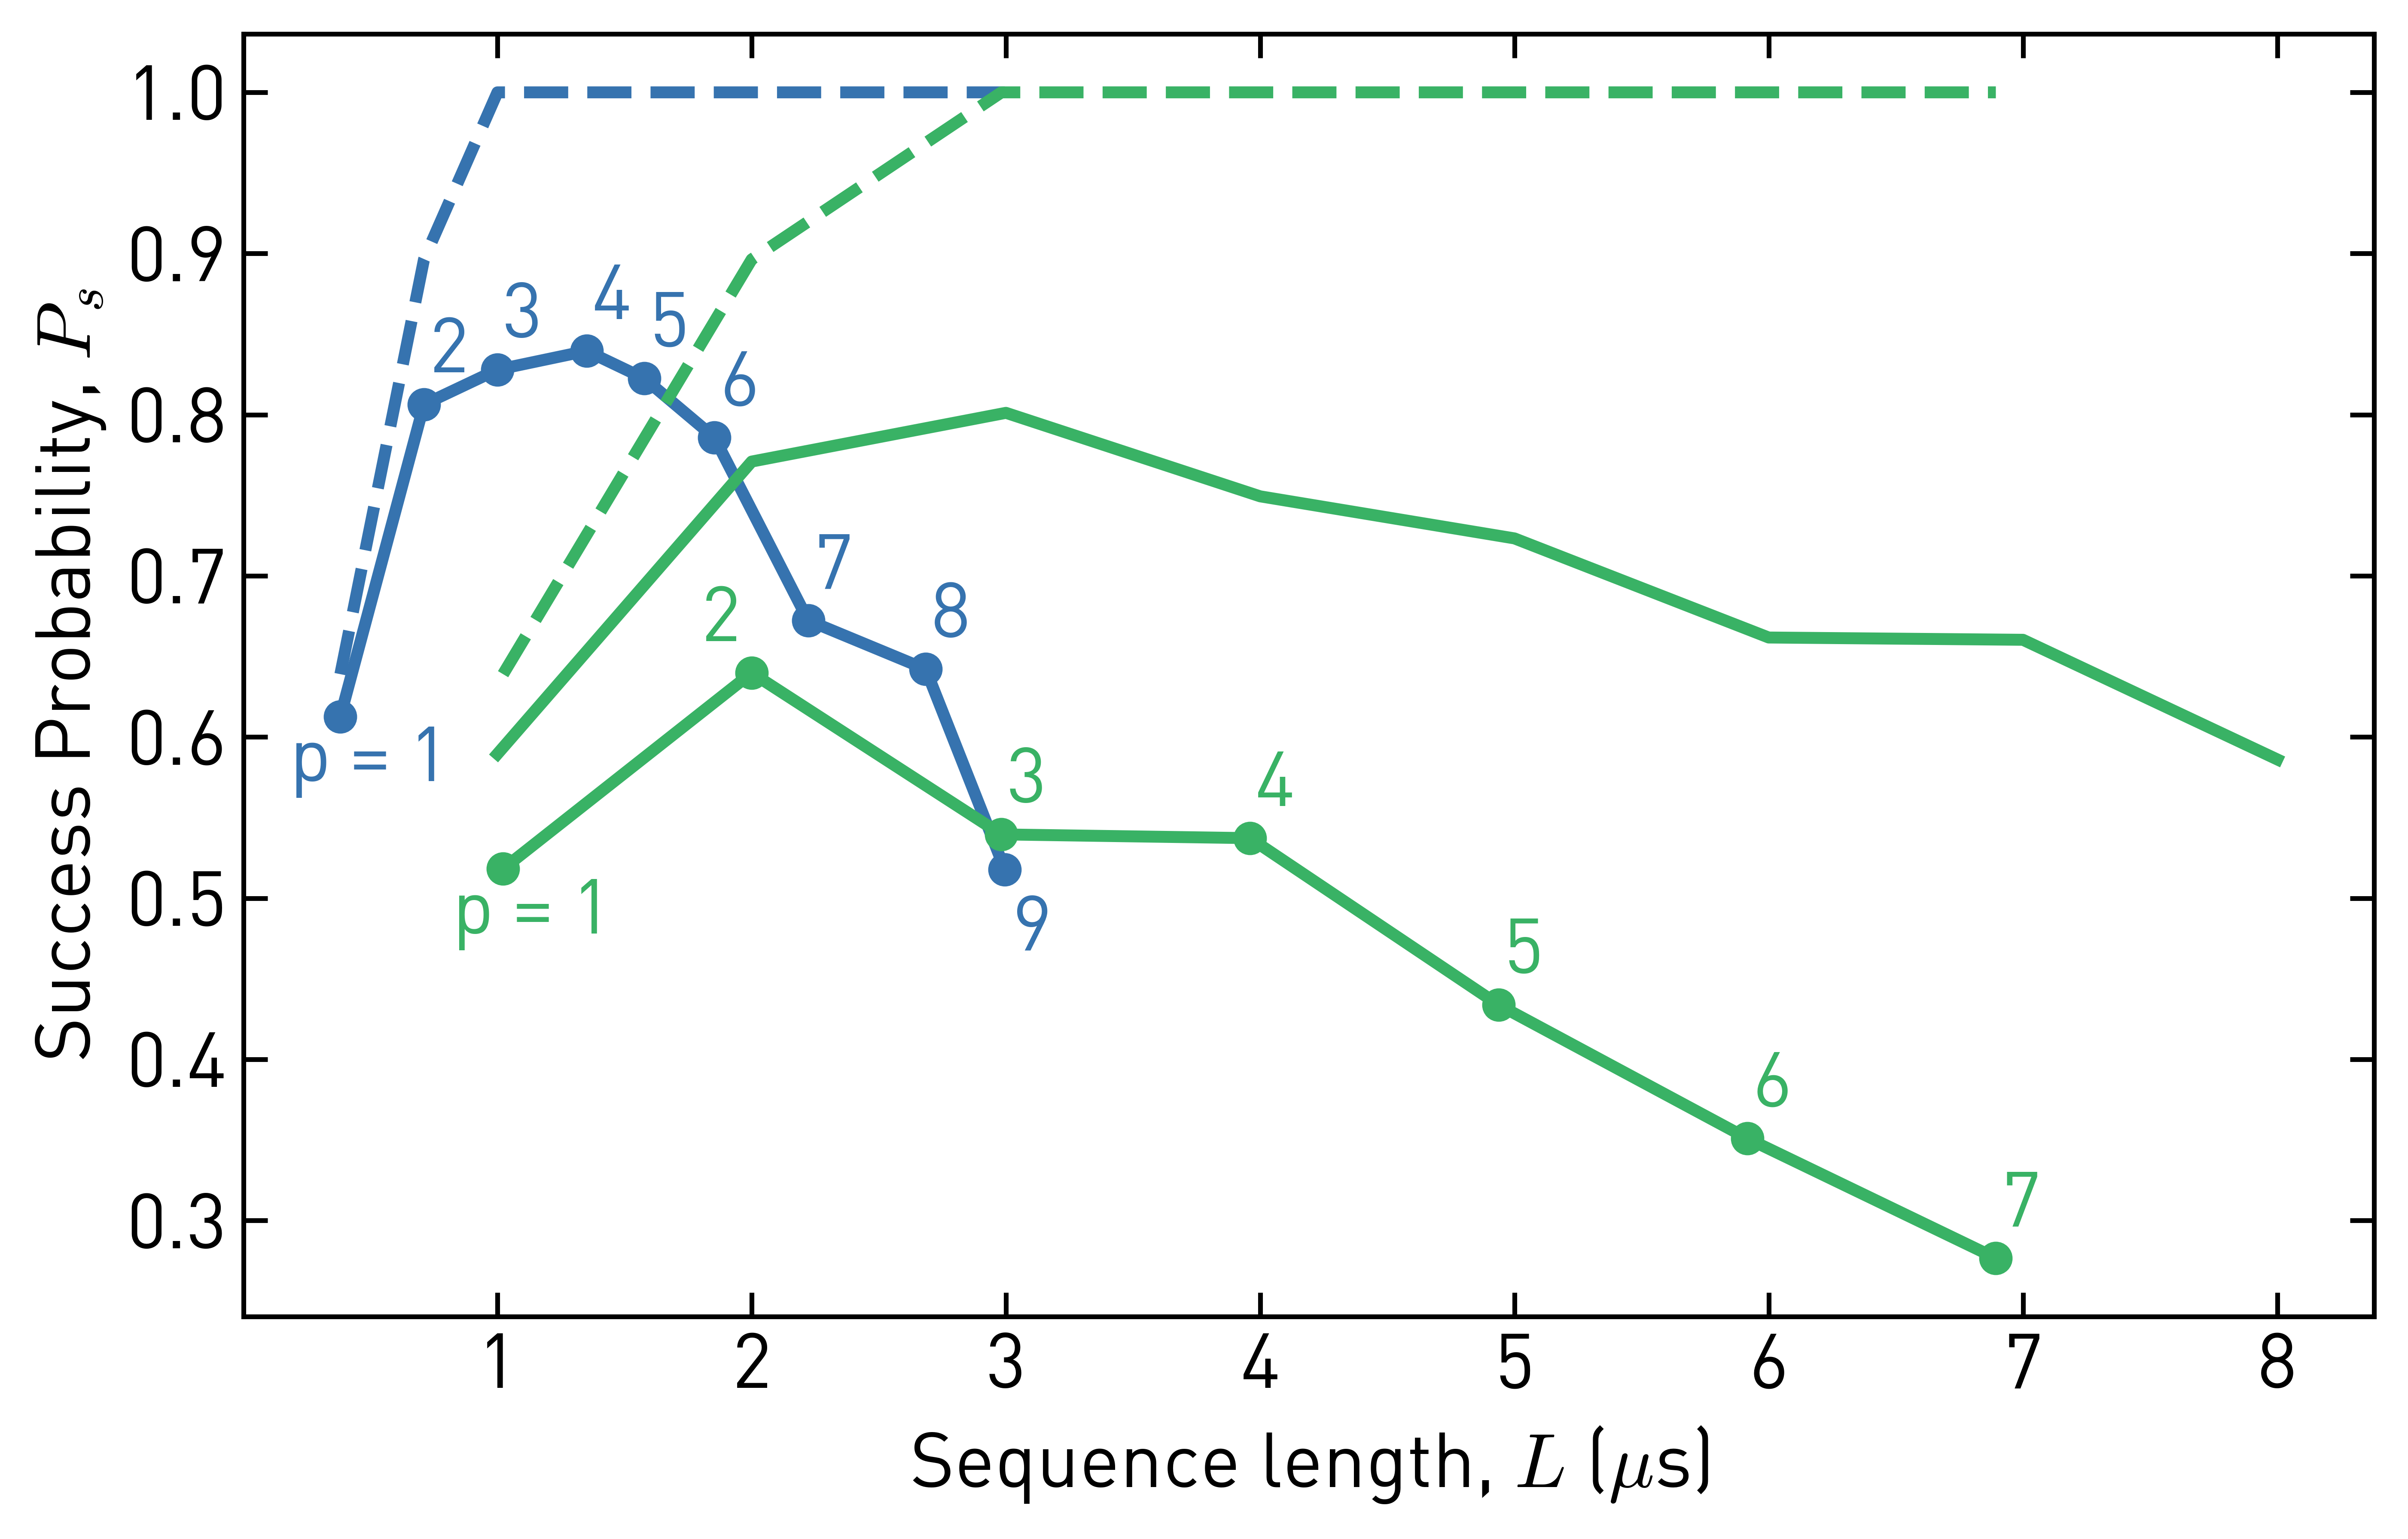

In [310]:
# plot 

# Option 1 
# fig, ax = plt.subplots(2, sharex=True, figsize=(8,7))
# ax[0].set_prop_cycle(color=[c_dir, c_dec])
# ax[0].violinplot(success_probs_traces_start_dir, positions=depths_traces, bw_method=0.4)
# ax[0].violinplot(success_probs_traces_start_dec, positions=depths_traces, bw_method=0.4)
# ax[0].plot(depths[:crop], success_probs_opt_start_dir[:crop], "-o", color=c_dir)
# ax[0].plot(depths[:crop], success_probs_opt_start_dec[:crop], "-o", color=c_dec)
# ax[0].plot(depths[:crop], success_prob_opt_nf_sim[:crop], '--o', color="grey")
# ax[1].set_ylabel("Sequence length, $L$ ($\mu$s)" )
# ax[1].set_xlabel("Depth, $p$")
# ax[0].set_ylim([0,1.05])
# ax[0].set_ylabel("Success Probability, $P_s$")

# Option 2
fig, ax = plt.subplots(1, sharex=True)
ax.set_prop_cycle(color=[c_dir, c_dec])
# ax.violinplot(success_probs_traces_start_dir, positions=lengths_dir[:4], bw_method=0.4, widths=0.25)
# ax.violinplot(success_probs_traces_start_dec, positions=lengths_dec[:4], bw_method=0.4,widths=0.25)

ax.plot(lengths_dir[:crop], success_probs_opt_start_dir[:crop], "-o", color=c_dir)
ax.plot(lengths_dec[:crop-2], success_probs_opt_start_dec[:crop-2], "-o", color=c_dec)
ax.plot(lengths_dir[:crop], success_prob_opt_nf_sim[:crop], '--', color=c_dir)
ax.plot(lengths_dec[:crop-2], success_prob_opt_nf_sim[:crop-2], '--', color=c_dec)
#annotate
for (i, l), p in zip(enumerate(lengths_dir[:crop]), success_probs_opt_start_dir[:crop]):
    if i == 0:
        ax.annotate("p = 1", (l,p), (l-0.2, p-0.04), color=c_dir)
    elif i==8:
        ax.annotate(f"{i+1}", (l,p), (l+0.03, p-0.05), color=c_dir)
    else:
        ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dir)
for (i, l), p in zip(enumerate(lengths_dec[:crop-2]), success_probs_opt_start_dec[:crop-2]):
#     if i == 0:
#         ax.annotate("p = 1", (l,p), (l, p-0.05), color=c_dec)
#     elif i==6:
#         ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dec)
#     elif i==2:
#         ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dec)
#     else:
#         ax.annotate(f"{i+1}", (l,p), (l+0.02, p-0.06), color=c_dec)
    if i == 0:
        ax.annotate("p = 1", (l,p), (l-0.2, p-0.04), color=c_dec)
#     elif i==6:
#         ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dec)
    elif i==1:
        ax.annotate(f"{i+1}", (l,p), (l-0.2, p+0.02), color=c_dec)
    else:
        ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dec)
# ax[0].plot(lengths_dec[:crop-2], success_probs_opt_start_dec[:crop-2], "-o", color=c_dec)

ax.set_xlabel("Sequence length, $L$ ($\mu$s)" )
ax.set_ylabel("Success Probability, $P_s$")


# TO COME: Master equation simulations ;)
ax.plot(np.arange(1,len(me) + 1), me, color=c_dec)
# ax.set_ylim([0,1])


# plot sequence lengths
# ax[1].plot(depths[:crop], lengths_dir[:crop], '-o', color=c_dir)
# ax[1].plot(depths[:crop], lengths_dec[:crop], '-o', color=c_dec)
# ax[1].plot(depths[:crop], lengths_dir_worst_case[:crop], '--', color=c_dir)


# ax[0].set_xscale("log")

In [389]:
fig.savefig(figsave_base + "ch5_qaoa_sequence_lengths_v1_{:%Y%m%d_%H%M%S}.png".format(datetime.datetime.now()))

In [86]:
11*0.0466+2*(0.01+ 0.106 + 0.015) + 2*(0.098+0.015+0.015)

1.0306000000000002

In [299]:
# ratio of sequence lengths 
print((np.array(lengths_dec))/(np.array(lengths_dir)))
print("Worst case:")
print((np.array(lengths_dec))/(np.array(lengths_dir_worst_case)))

[2.6744186  2.8125     2.98222222 2.93092105 3.12957746 3.19184652
 3.102      2.93377483 2.95548961 3.11988717]
Worst case:
[2.58426966 2.69461078 2.72764228 2.74153846 2.75       2.76141079
 2.76470588 2.76875    2.77437326 2.77540778]


In [324]:
depths_to_plot = np.arange(1,5)
labels = ['|000$\\rangle$', '|001$\\rangle$', '|010$\\rangle$', 
          '|011$\\rangle$', '|100$\\rangle$', '|101$\\rangle$', '|110$\\rangle$', 
          '|111$\\rangle$'] # rewrite state labels to not use math font for the numbers

In [325]:
# info
print("Optimal start")
print(success_probs_opt_start_dir[:crop])
print(success_probs_opt_start_dec[:crop])
print("Traj")
print(np.amax(success_probs_traces_start_dir))
print(np.amax(success_probs_traces_start_dec))

Optimal start
[0.6127538671998316, 0.8063748547396381, 0.8279551820728291, 0.8395763226126772, 0.8224758368372195, 0.7858428314337133, 0.6723543400713436, 0.6421546856163949, 0.5178660225900404]
[0.5182425089271853, 0.6398292697187627, 0.5395984219513631, 0.5372864879877794, 0.43383028333215573, 0.35102459016393445, 0.27669835057310593, 0.3683784876668015, 0.22973073214153253]
Traj
0.8285479452054795
0.6936043906810035


c:\users\nathan\masterthesis\code\env\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



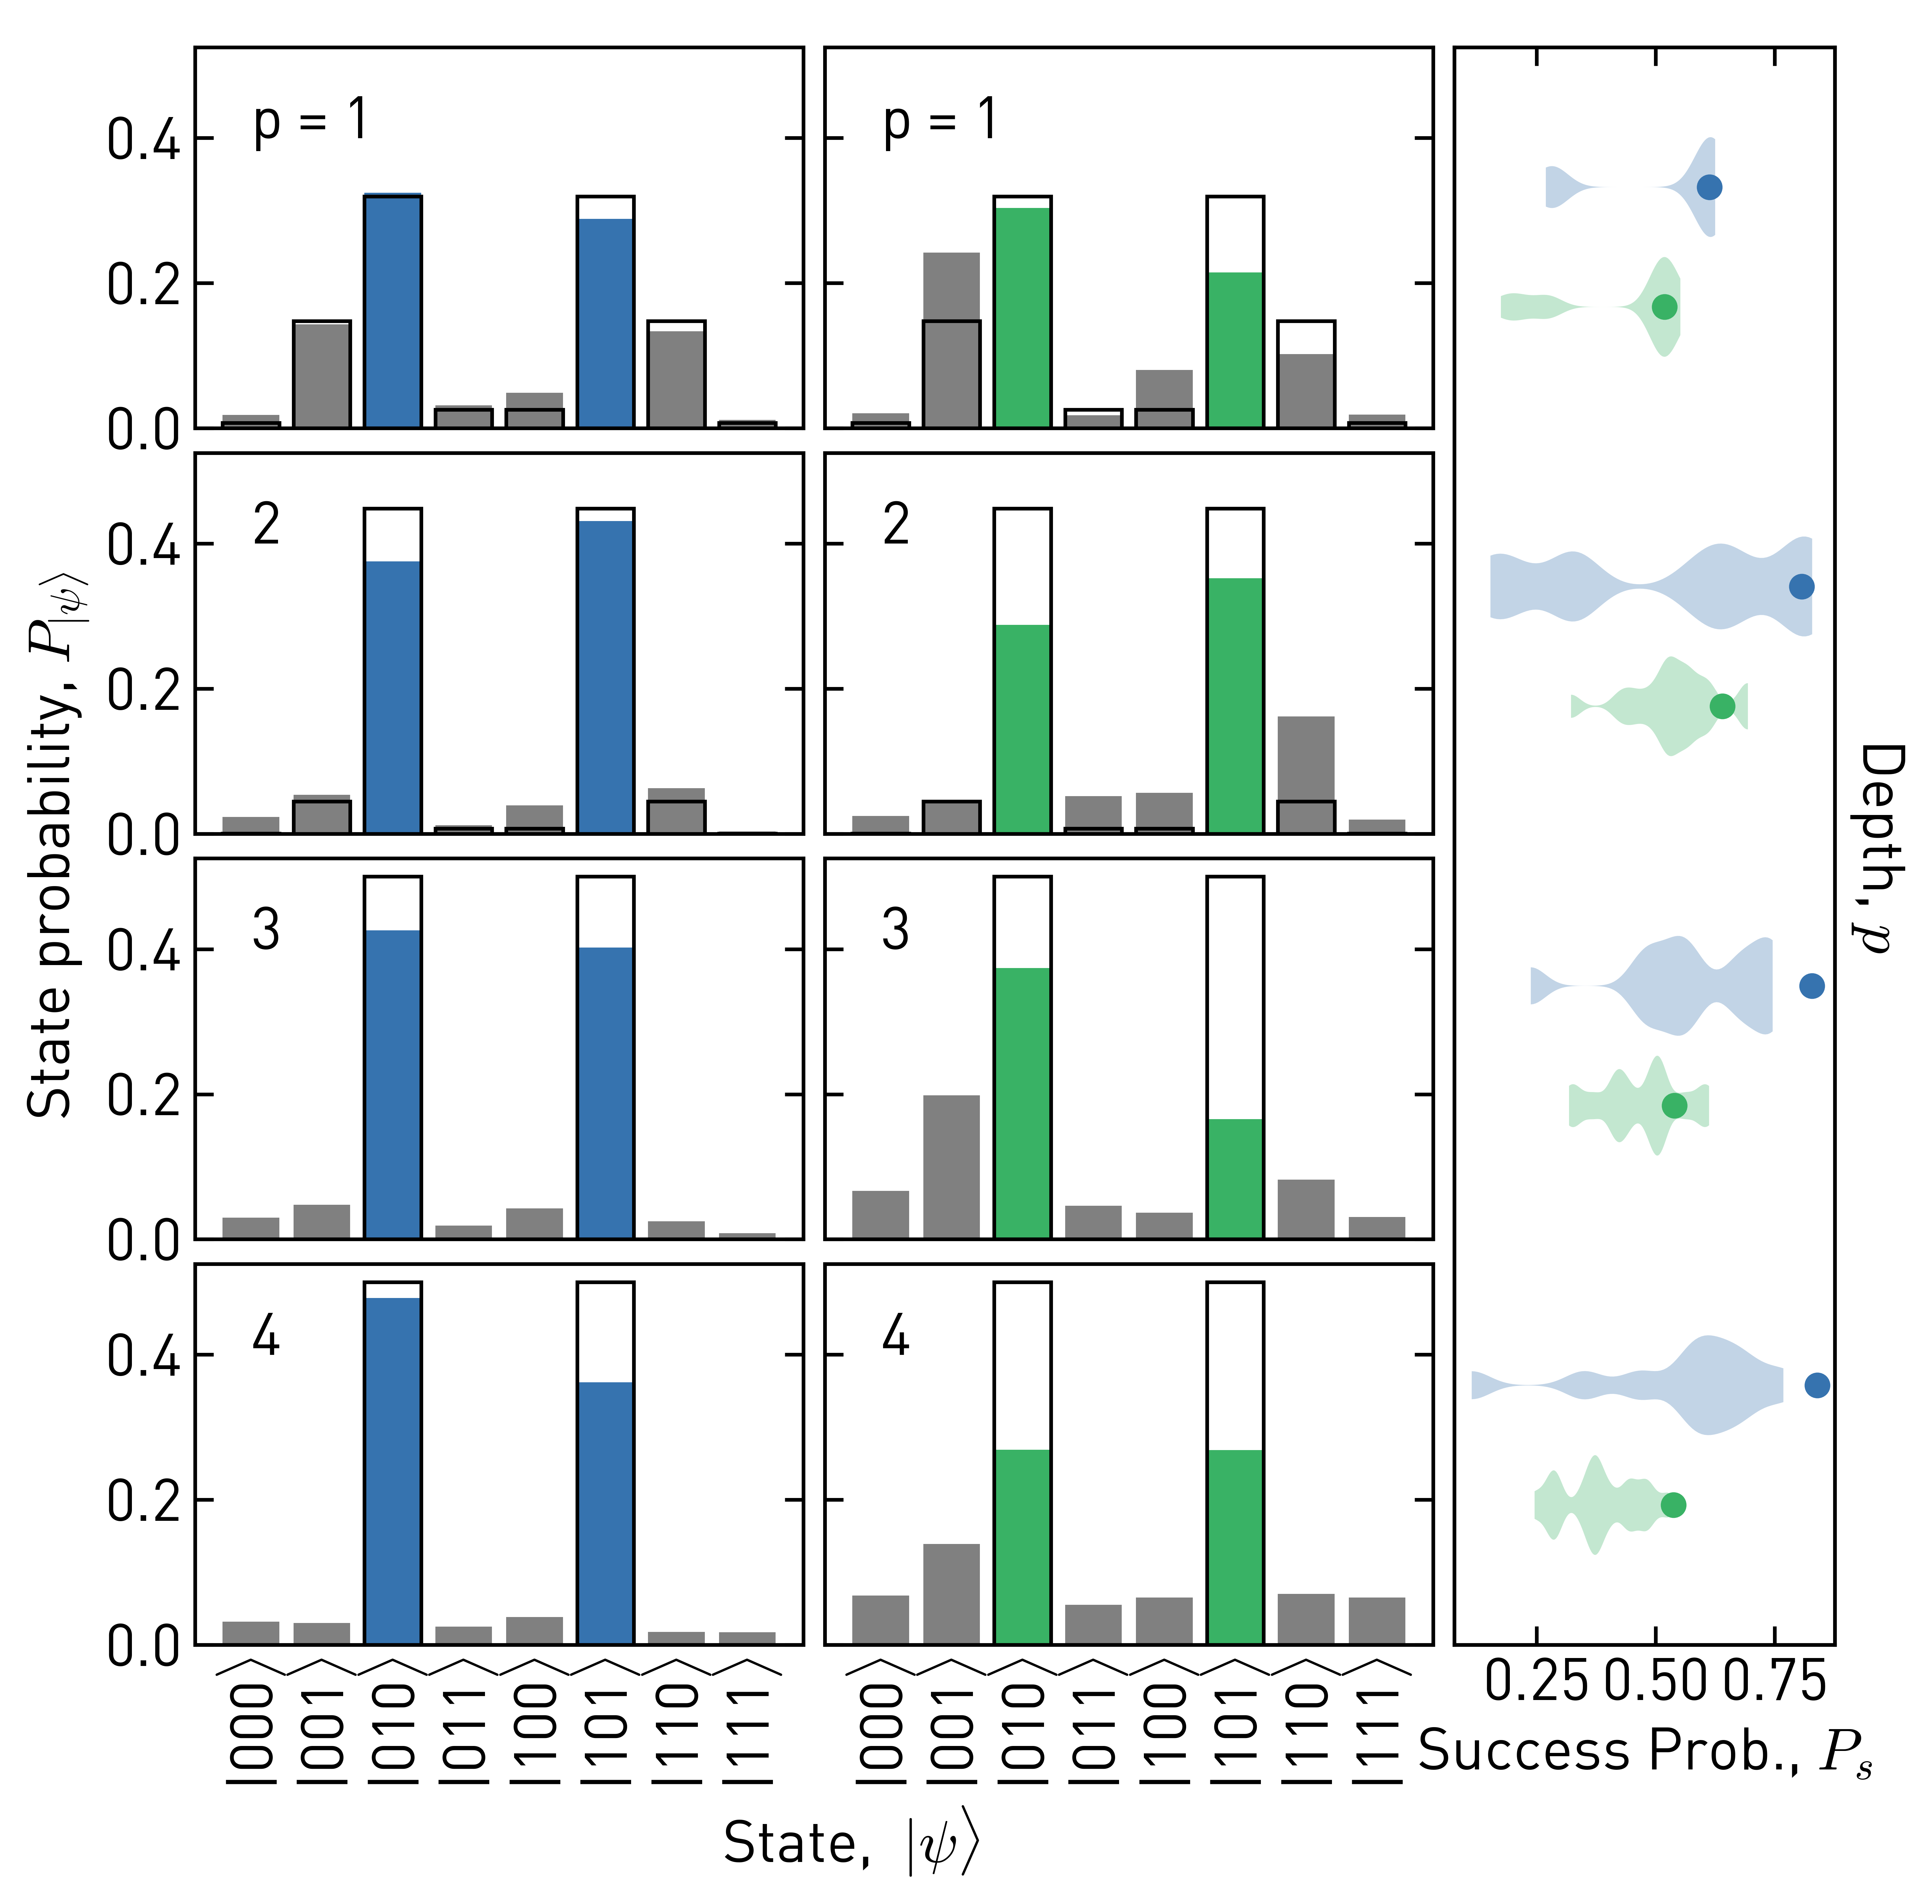

In [326]:

fig, axes = plt.subplots(len(depths_to_plot), 3, sharex=True, sharey=True, figsize=(8,8), 
                         gridspec_kw={'width_ratios': [1.6, 1.6,1]}) 
# plt.rcParams['mathtext.fontset']  = 'dejavuserif' # change math font for the ket which renders better with DINPro numbers

for (i, ax), res, p_nf_sim in zip(enumerate(axes.T[0]), res_opt_start_dir, state_prob_opt_nf_sim):
    ax.annotate(f'p = {i+1}' if i == 0 else f'{i+1}', [0,0.4] )
    ax.bar(res['state_probs'].keys(), res['state_probs'].values(), color='grey')
    ax.bar(cs_to_phys(correct_states), [p for s, p in res['state_probs'].items() if s in cs_to_phys(correct_states)] , 
               color=c_dir, label="$P_s$: {:.3f}".format(1))
    ax.bar(res['state_probs'].keys(), p_nf_sim,
           fill=False, linewidth=1, edgecolor='k', 
           label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
#             ax.legend()
    ax.xaxis.set_ticks(np.arange(len(res['state_probs'].keys())))
    ax.xaxis.set_ticklabels(res['state_probs'].keys(),  rotation='vertical')  
    ax.tick_params(top=False, bottom=False)
#     ax.patch.set_facecolor(c_dir)
#     ax.patch.set_alpha(0.2)
    
for (i, ax), res, p_nf_sim in zip(enumerate(axes.T[1]), res_opt_start_dec, state_prob_opt_nf_sim):
    ax.annotate(f'p = {i+1}' if i == 0 else f'{i+1}', [0,0.4] )
    ax.bar(res['state_probs'].keys(), res['state_probs'].values(), color='grey')
    ax.bar(cs_to_phys(correct_states), 
           [p for s, p in res['state_probs'].items() if s in cs_to_phys(correct_states)] , 
               color=c_dec, label="$P_s$: {:.3f}".format(1))
    ax.bar(res['state_probs'].keys(), p_nf_sim, 
           fill=False, linewidth=1, edgecolor='k', 
           label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
#     ax.legend()
    ax.xaxis.set_ticks(np.arange(len(res['state_probs'].keys())))
    ax.xaxis.set_ticklabels(labels,  rotation='vertical')
    ax.tick_params(top=False, bottom=False)

#     ax.xaxis.set_ticks_position('bottom')
#     ax.patch.set_facecolor(c_dec)
#     ax.patch.set_alpha(0.2)
#     ax.set_facecolor(c_dec, alpha=0.2)

    
gs = axes[3, 2].get_gridspec()
# remove the underlying axes
for ax in axes[:, 2]:
    ax.remove()
axbig = fig.add_subplot(gs[:, -1])
axbig.set_prop_cycle(color=[c_dir, c_dec])
axbig.violinplot(success_probs_traces_start_dir, positions=np.array(depths[:4]) - 0.15, 
                 bw_method=0.4, widths=0.25, vert=False, showextrema=False)
axbig.violinplot(success_probs_traces_start_dec, positions=np.array(depths[:4]) + 0.15, 
                 bw_method=0.4,widths=0.25, vert=False, showextrema=False)
axbig.plot(success_probs_opt_start_dir[:4], np.array(depths[:4]) - 0.15 , "o", color=c_dir)
axbig.plot(success_probs_opt_start_dec[:4], np.array(depths[:4]) + 0.15, "o", color=c_dec)
axbig.set_ylim([4.5, 0.5])
axbig.set_yticks([])
axbig.set_yticklabels([])
axbig.set_xlabel('Success Prob., $P_s$' )
# axforxlabel = axbig.twiny()
# axforxlabel.set_xlabel('Success Prob., $P_s$')

axforylabel = axbig.twinx()
axforylabel.set_ylabel('Depth, $p$', va='bottom', rotation=270)
axforylabel.set_yticks([])
plt.subplots_adjust(wspace=0.04, hspace=0.04/fig_size[1]*fig_size[0])

# common label
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel(r"State,  $|\psi\rangle$")
ax.xaxis.set_label_coords(0.4, -0.1) # move label because of vertical states
plt.ylabel(r"State probability, $P_{|\psi\rangle}$")

# fig.tight_layout()
plt.show()
# plt.rcParams['mathtext.fontset']  = 'cm' # change math font back


In [239]:
fig.savefig(figsave_base + "ch5_qaoa_state_histograms_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()))

### Figure for poster

[0.6127538671998316, 0.8063748547396381, 0.8279551820728291, 0.8395763226126772, 0.8224758368372195, 0.7858428314337133, 0.6723543400713436, 0.6421546856163949, 0.5178660225900404]
[0.5182425089271853, 0.6398292697187627, 0.5395984219513631, 0.5372864879877794, 0.43383028333215573, 0.35102459016393445, 0.27669835057310593, 0.3683784876668015, 0.22973073214153253]


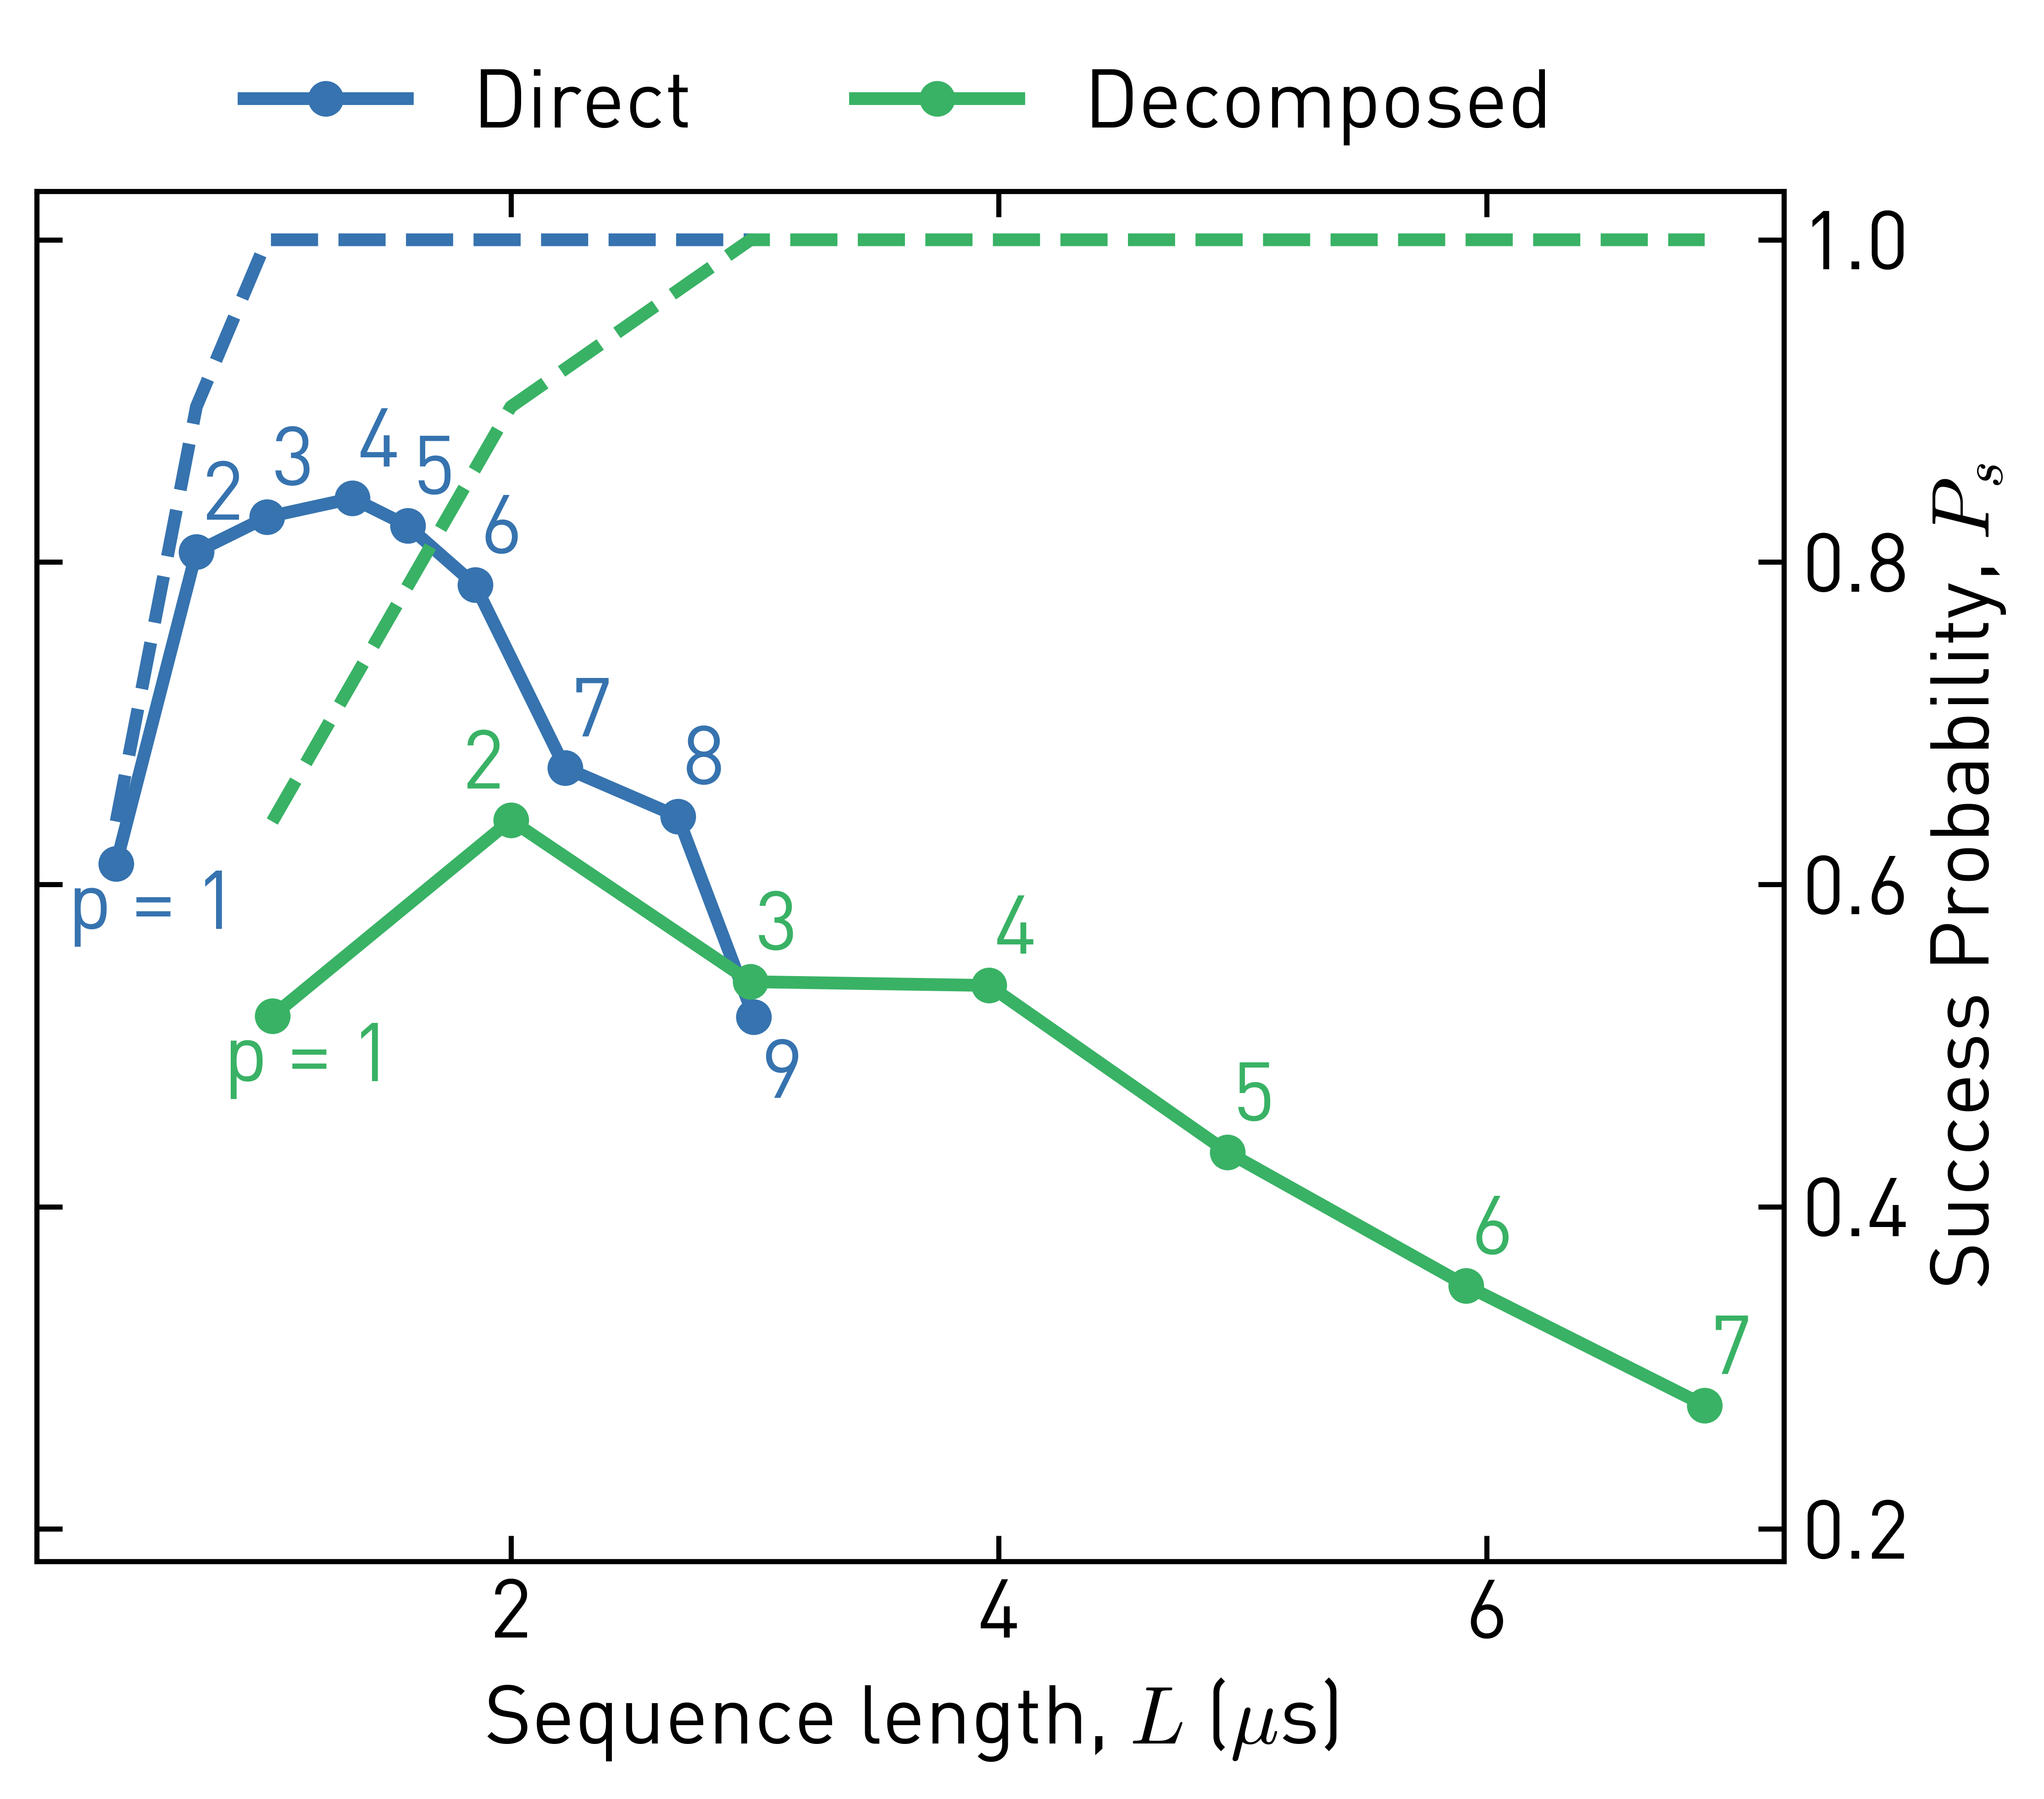

In [323]:
print("Optimal start")
print(success_probs_opt_start_dir[:crop])
print(success_probs_opt_start_dec[:crop])

# plot 

fig, ax = plt.subplots(1, sharex=True, figsize=(fig_size[1] + 1.2,fig_size[1]))
ax.set_prop_cycle(color=[c_dir, c_dec])

ax.plot(lengths_dir[:crop], success_probs_opt_start_dir[:crop], "-o", color=c_dir, label='Direct')
ax.plot(lengths_dec[:crop-2], success_probs_opt_start_dec[:crop-2], "-o", color=c_dec, label='Decomposed')
ax.plot(lengths_dir[:crop], success_prob_opt_nf_sim[:crop], '--', color=c_dir)
ax.plot(lengths_dec[:crop-2], success_prob_opt_nf_sim[:crop-2], '--', color=c_dec)
#annotate
for (i, l), p in zip(enumerate(lengths_dir[:crop]), success_probs_opt_start_dir[:crop]):
    if i == 0:
        ax.annotate("p = 1", (l,p), (l-0.2, p-0.04), color=c_dir)
    elif i==8:
        ax.annotate(f"{i+1}", (l,p), (l+0.03, p-0.05), color=c_dir)
    else:
        ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dir)
for (i, l), p in zip(enumerate(lengths_dec[:crop-2]), success_probs_opt_start_dec[:crop-2]):

    if i == 0:
        ax.annotate("p = 1", (l,p), (l-0.2, p-0.04), color=c_dec)

    elif i==1:
        ax.annotate(f"{i+1}", (l,p), (l-0.2, p+0.02), color=c_dec)
    else:
        ax.annotate(f"{i+1}", (l,p), (l+0.02, p+0.02), color=c_dec)


ax.set_xlabel("Sequence length, $L$ ($\mu$s)" )
ax.set_ylim([0.18,1.03])
ax.set_yticklabels([])
axforylabel = ax.twinx()
axforylabel.set_ylim([0.18,1.03])
axforylabel.set_ylabel("Success Probability, $P_s$")
# ax.yaxis.tick_right()
ax.legend(loc=[0.1,1.01], ncol=2)
# TO COME: Master equation simulations ;)
# ax[0].plot(np.arange(1,10), me)
# ax[0].set_ylim([0,1])


In [136]:
fig.savefig(figsave_base + "ch5_qaoa_sequence_lengths_poster_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()))

In [317]:
depths_to_plot = [1,3]
labels = ['|000$\\rangle$', '|001$\\rangle$', '|010$\\rangle$', 
          '|011$\\rangle$', '|100$\\rangle$', '|101$\\rangle$', '|110$\\rangle$', 
          '|111$\\rangle$'] # rewrite state labels to not use math font for the numbers

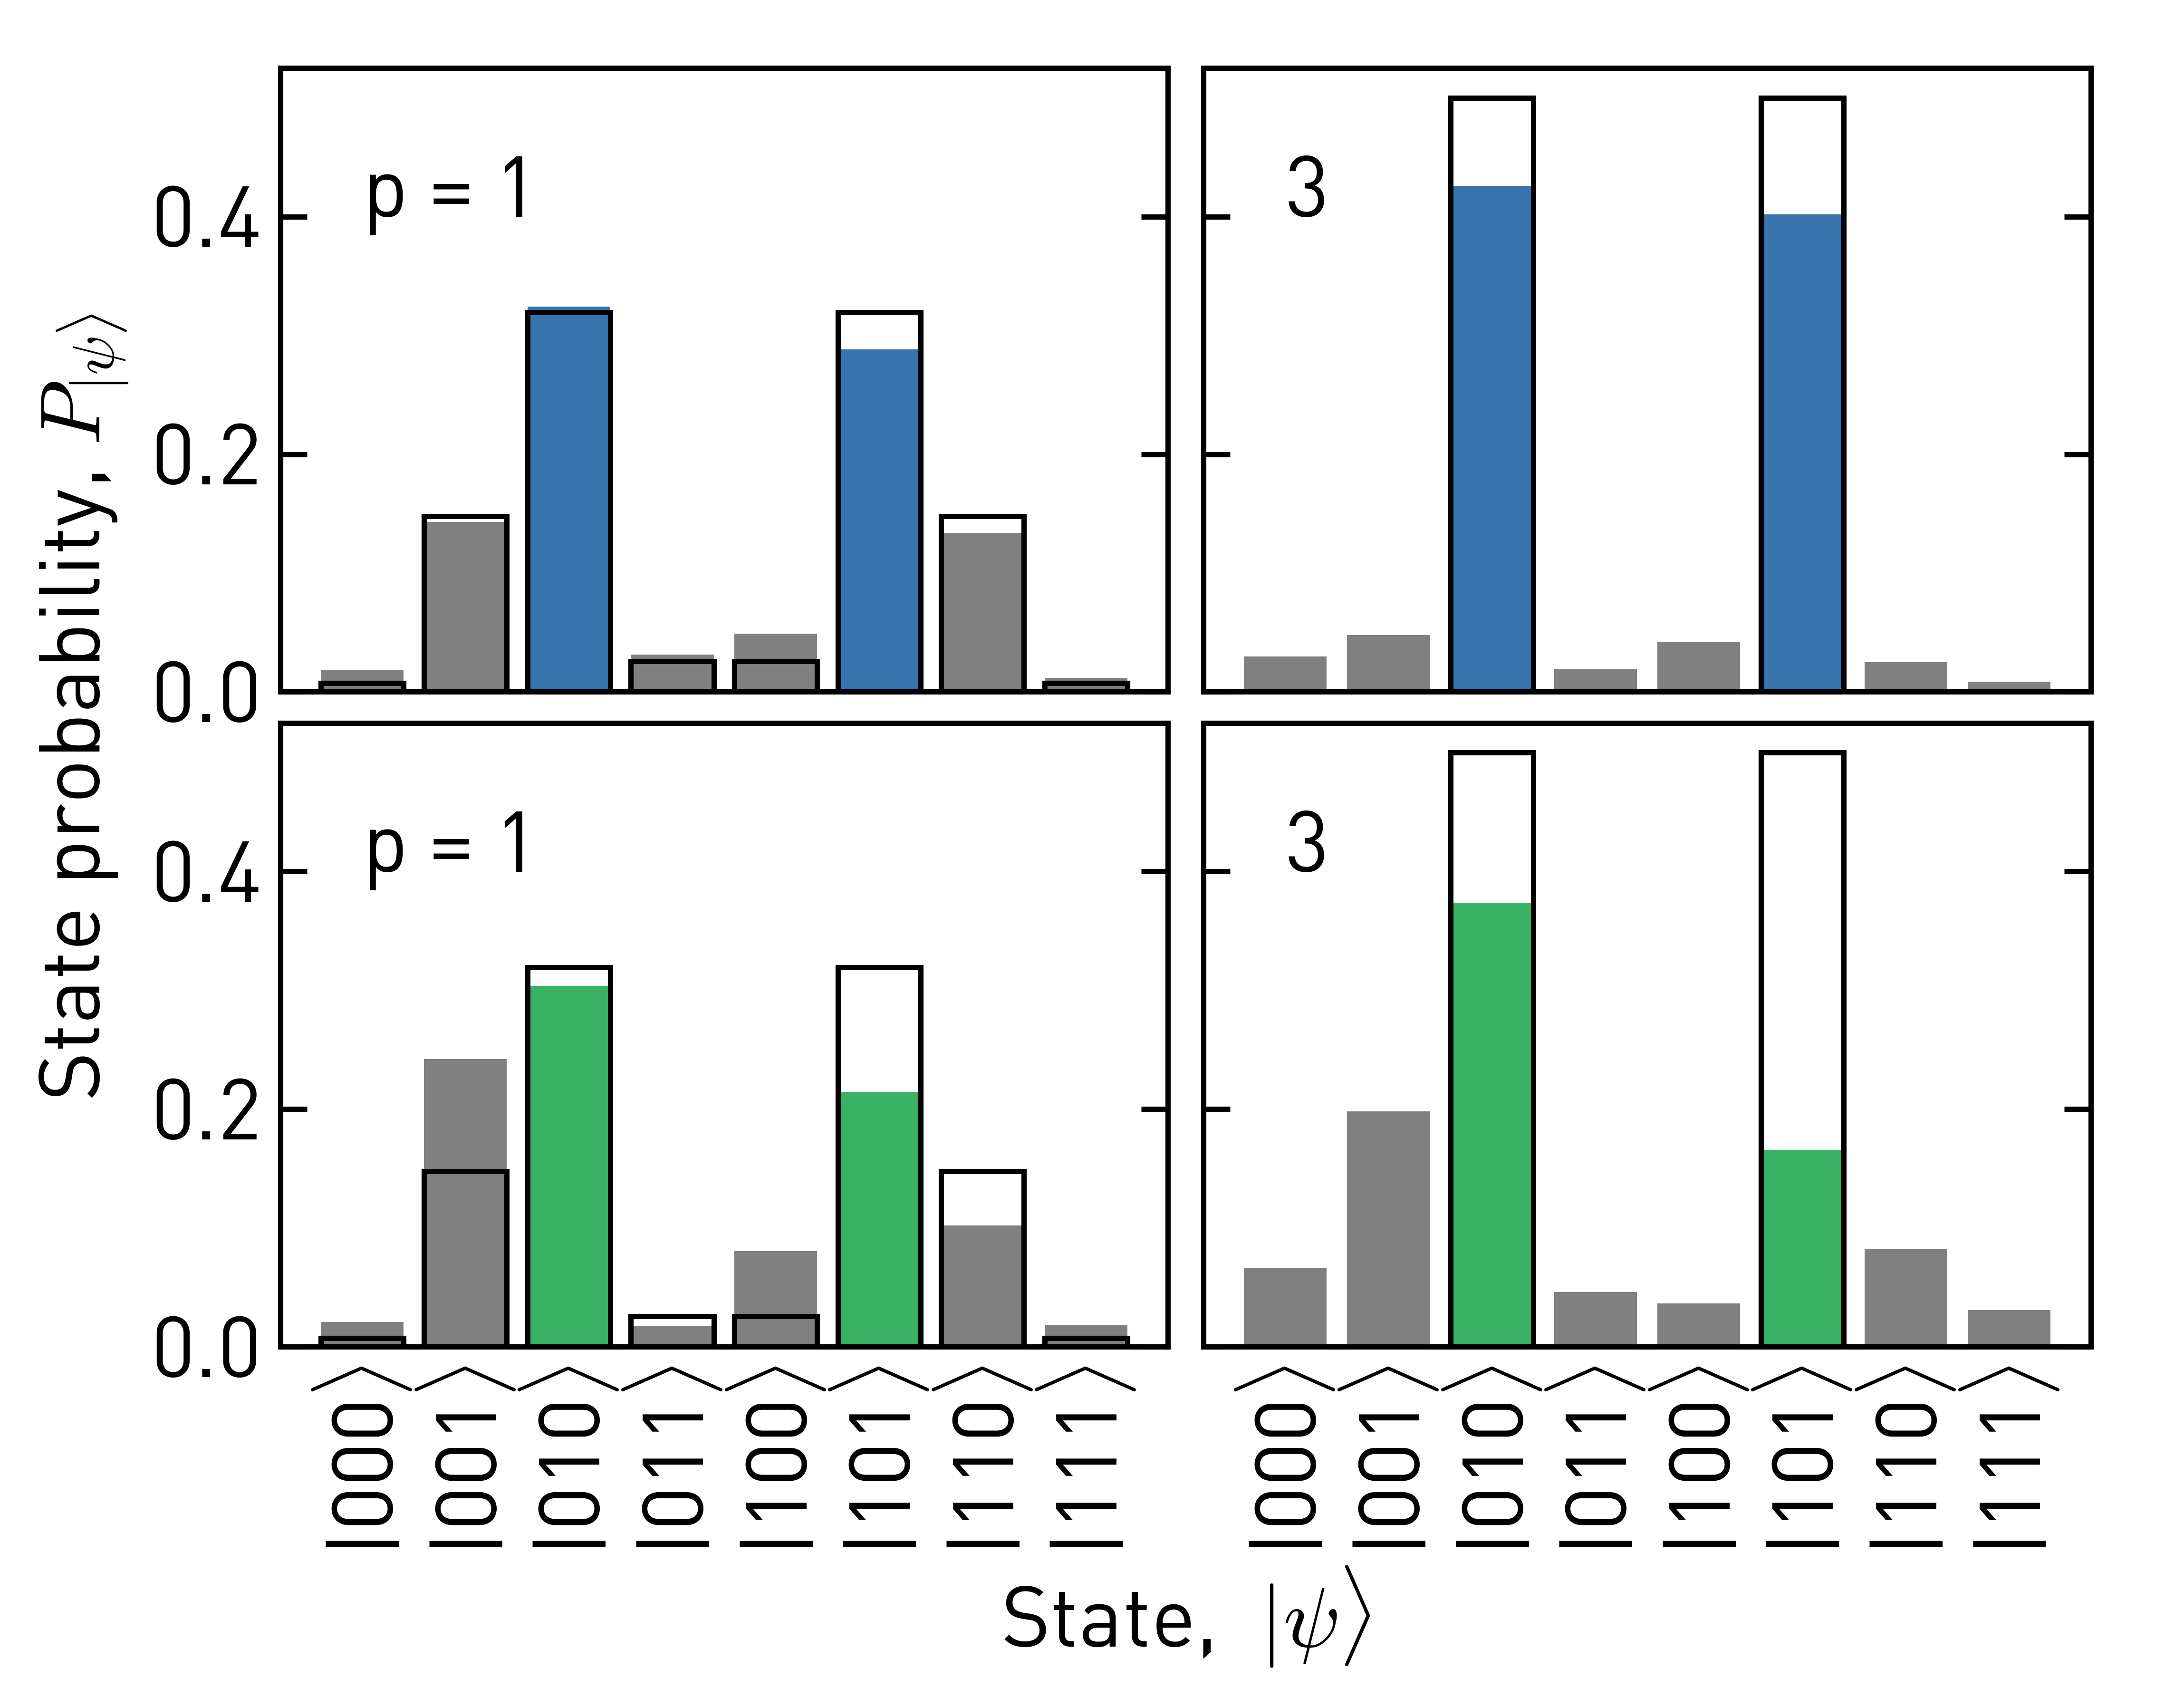

In [321]:
fig, axes = plt.subplots(len(depths_to_plot), 2, sharex=True, sharey=True, figsize=(fig_size[1]+1.2,fig_size[1])) 
# plt.rcParams['mathtext.fontset']  = 'dejavuserif' # change math font for the ket which renders better with DINPro numbers
idx_to_plot = np.array(depths_to_plot)-1
for (i, ax), res, p_nf_sim in zip(enumerate(axes[0]), np.array(res_opt_start_dir)[idx_to_plot], np.array(state_prob_opt_nf_sim)[idx_to_plot]):
    ax.annotate(f'p = {depths_to_plot[i]}' if i == 0 else f'{depths_to_plot[i]}', [0,0.4] )
    ax.bar(res['state_probs'].keys(), res['state_probs'].values(), color='grey')
    ax.bar(cs_to_phys(correct_states), [p for s, p in res['state_probs'].items() if s in cs_to_phys(correct_states)] , 
               color=c_dir, label="$P_s$: {:.3f}".format(1))
    ax.bar(res['state_probs'].keys(), p_nf_sim,
           fill=False, linewidth=1, edgecolor='k', 
           label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
#             ax.legend()
    ax.xaxis.set_ticks(np.arange(len(res['state_probs'].keys())))
    ax.xaxis.set_ticklabels(res['state_probs'].keys(),  rotation='vertical')  
    ax.tick_params(top=False, bottom=False)
#     ax.patch.set_facecolor(c_dir)
#     ax.patch.set_alpha(0.2)
    
for (i, ax), res, p_nf_sim in zip(enumerate(axes[1]), np.array(res_opt_start_dec)[idx_to_plot], np.array(state_prob_opt_nf_sim)[idx_to_plot]):
    ax.annotate(f'p = {depths_to_plot[i]}' if i == 0 else f'{depths_to_plot[i]}', [0,0.4] )
    ax.bar(res['state_probs'].keys(), res['state_probs'].values(), color='grey')
    ax.bar(cs_to_phys(correct_states), 
           [p for s, p in res['state_probs'].items() if s in cs_to_phys(correct_states)] , 
               color=c_dec, label="$P_s$: {:.3f}".format(1))
    ax.bar(res['state_probs'].keys(), p_nf_sim, 
           fill=False, linewidth=1, edgecolor='k', 
           label="$P_s$ noise-free sim.: {:.3f}".format(success_prob_theory))
#     ax.legend()
    ax.xaxis.set_ticks(np.arange(len(res['state_probs'].keys())))
    ax.xaxis.set_ticklabels(labels,  rotation='vertical')
    ax.tick_params(top=False, bottom=False)

#     ax.xaxis.set_ticks_position('bottom')
#     ax.patch.set_facecolor(c_dec)
#     ax.patch.set_alpha(0.2)
#     ax.set_facecolor(c_dec, alpha=0.2)

plt.subplots_adjust(wspace=0.05/(fig_size[1]+1.2)*(fig_size[1]), hspace=0.05)

# common label
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
l = ax.set_xlabel(r"State,  $|\psi\rangle$")
ax.xaxis.set_label_coords(0.5, -0.17) # move label because of vertical states
plt.ylabel(r"State probability, $P_{|\psi\rangle}$")
plt.gcf().subplots_adjust(bottom=0.2)
# fig.tight_layout()
# plt.show()
# plt.rcParams['mathtext.fontset']  = 'cm' # change math font back


In [164]:
fig.savefig(figsave_base + "ch5_qaoa_state_histograms_[1,3]_{:%Y%m%d_%H%M%S}.pdf".format(datetime.datetime.now()),  bbox='tight', pad_inches = 1)

### Leakage

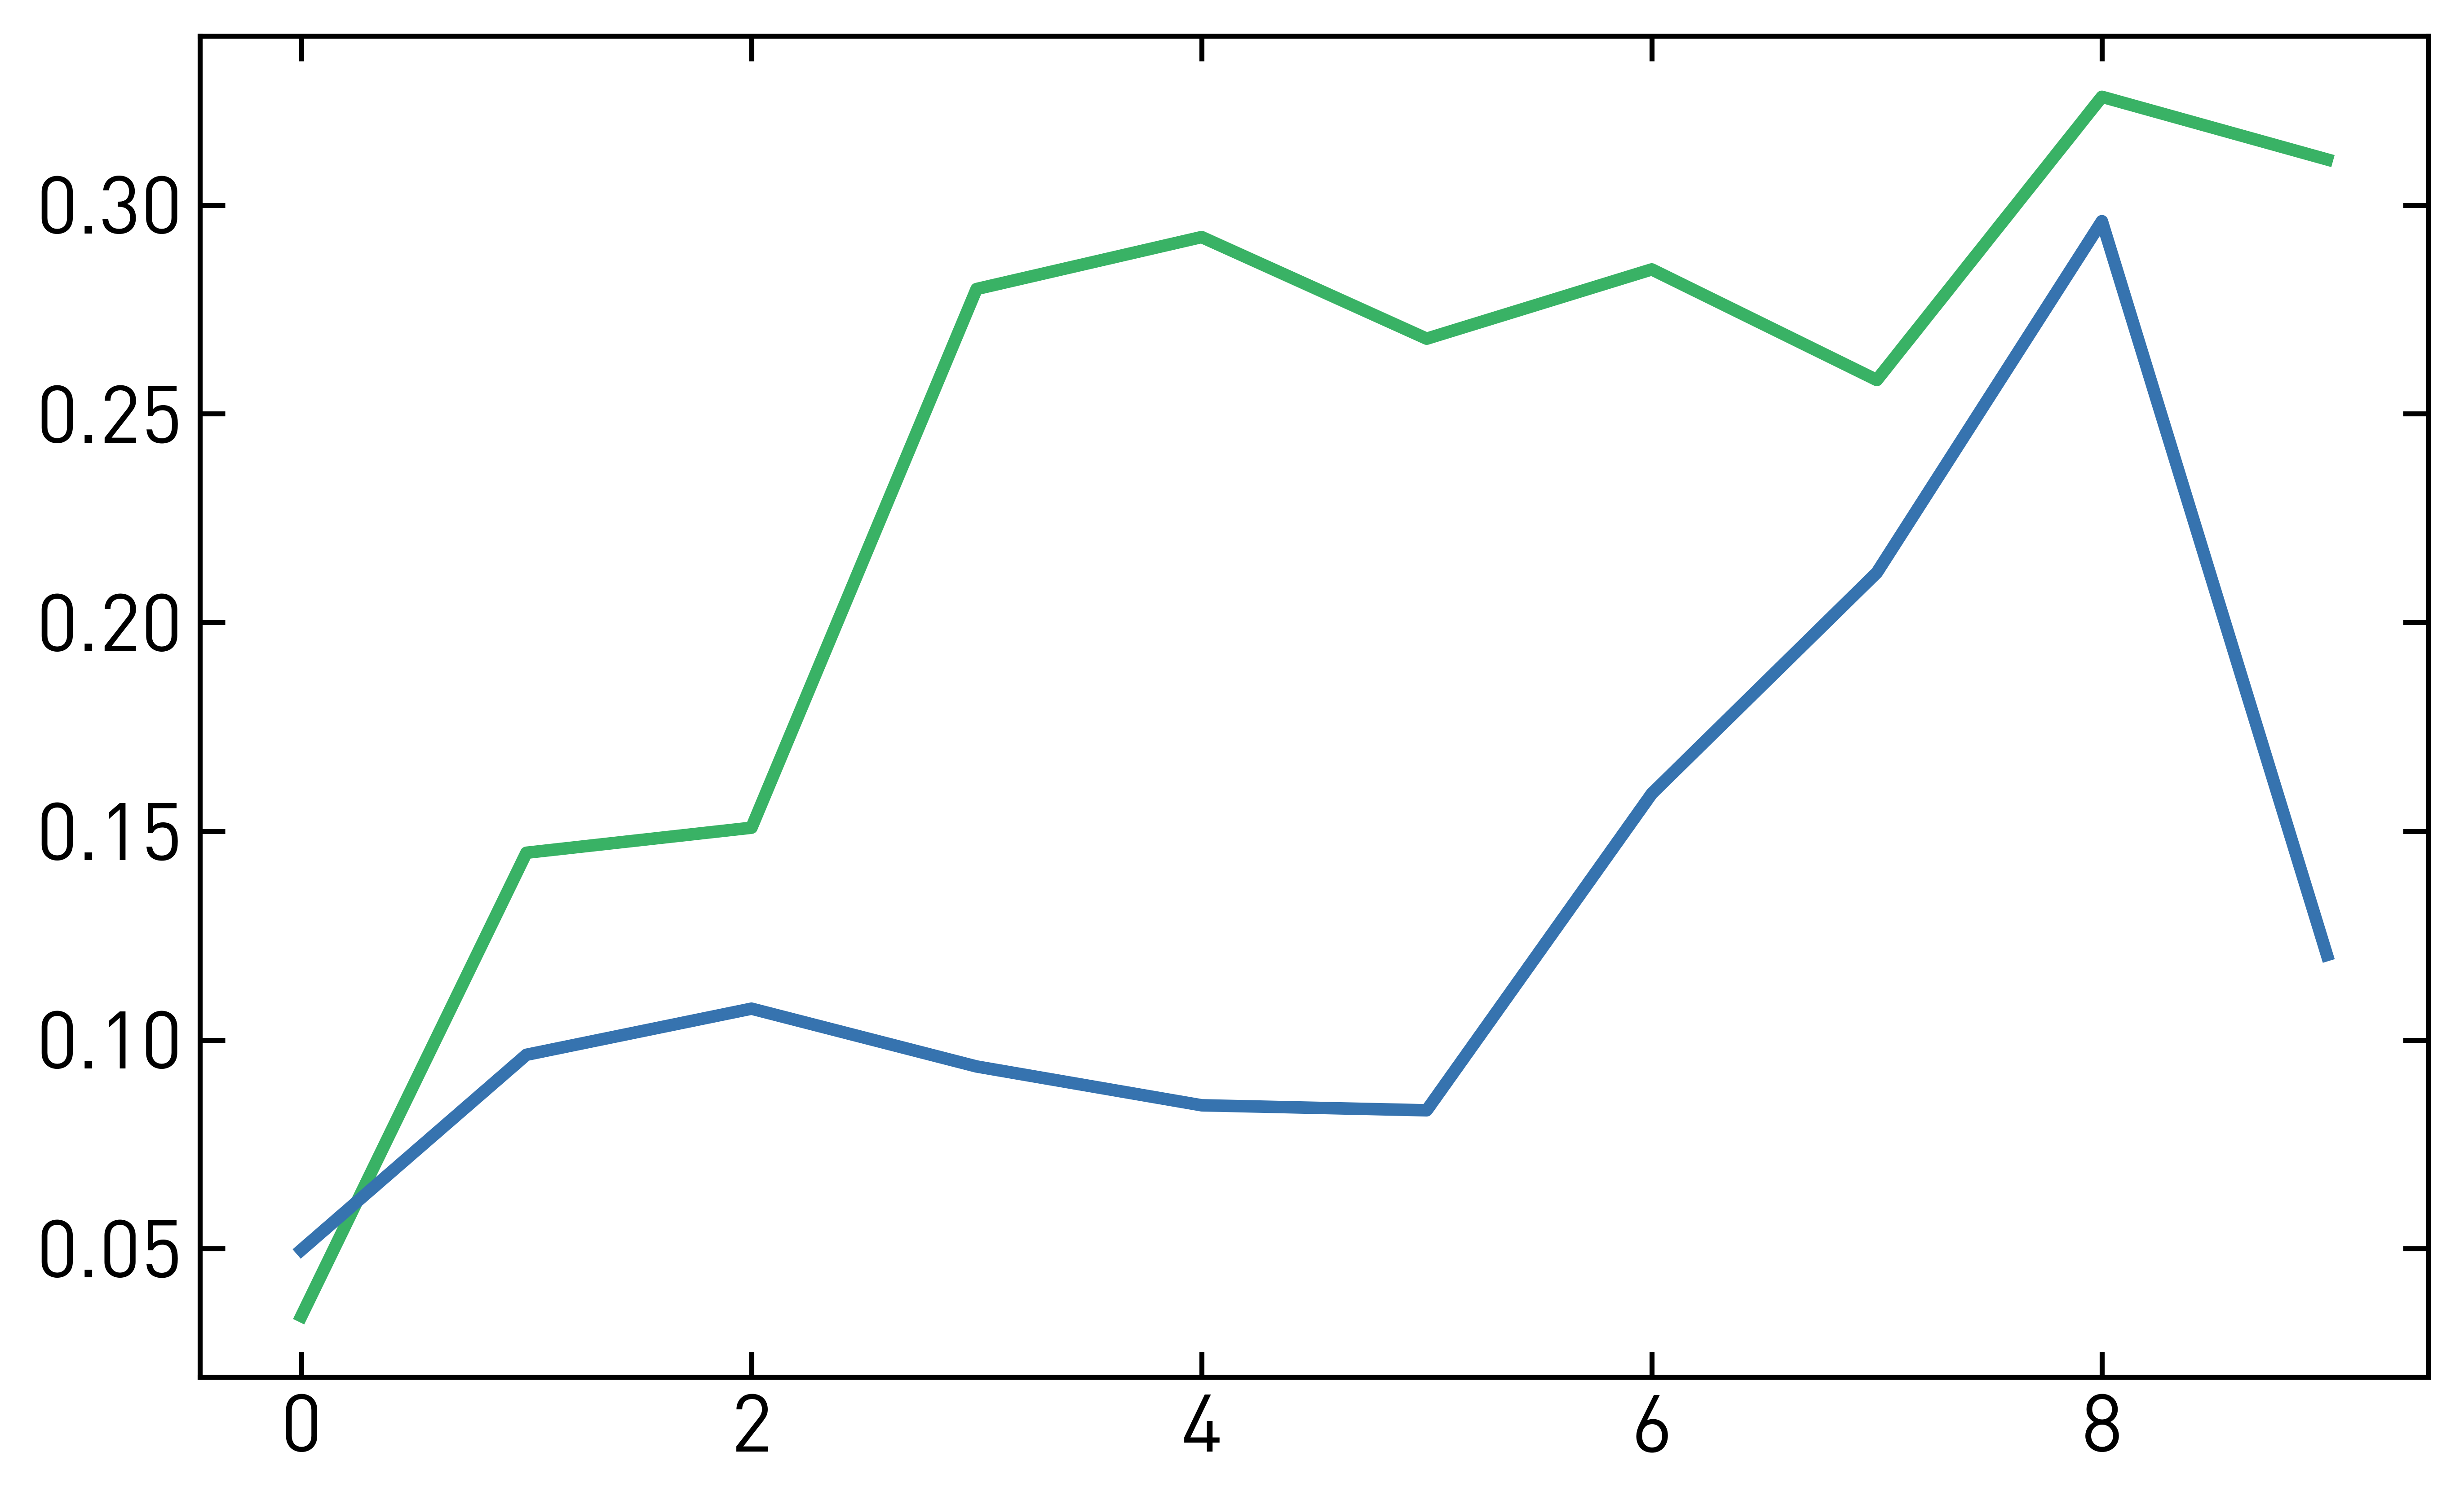

In [359]:
l_dec = np.array([res['leakage_prob'] for res in res_opt_start_dec])
l_dir = np.array([res['leakage_prob'] for res in res_opt_start_dir])

plt.plot(l_dec, color=c_dec)
plt.plot(l_dir, color=c_dir)


In [360]:
print(l_dec)
print(l_dir)

[0.03385 0.14485 0.15085 0.2799  0.29235 0.268   0.2846  0.2581  0.32595
 0.31095]
[0.0497  0.09645 0.1075  0.09365 0.08435 0.08315 0.159   0.21195 0.29615
 0.12035]


In [2]:
# example with outfit

In [7]:
ncolors = 8
nbits = np.log2(ncolors)
nitems  =  25

noutfits = 2**(nbits*nitems)
print(noutfits)
print(noutfits/1e9/3600/24/365) # time in years

3.777893186295716e+22
1197962.0707431876


# Scratchpad

In [245]:

reload(mqm)
reload(qaoa)
reload(tda)
np.random.seed(2)
n_iter = 10
n_rep = 10

optimal_params={
    1: dict(g=[0.67848787], b=[3.9269908]),
    2: dict(g=[0.64186931,1.15633934], b=[1.08778431,0.56831448]),
    3: dict(g=[ 0.91293813,  1.38149213,  2.64575812], b=[4.25592023,  6.8627972,  -0.47658777]),
    4: dict(g= [0.79047109, 1.29788154, 2.65529822, 1.02307546 ], b=[ 0.9663438, 3.66163585, 5.75941282 ,6.01503621]),
    5: dict(g = [0.62732382, 0.00640932, 1.21334409, 0.32948633, 1.03519245], b=[0.21928593 ,1.03185706, 0.84183517, 3.16511823, 3.56522479] ),
    6: dict(g=[1.03885048, 1.35146962, 2.06623968, 2.43631484, 3.12286653, 2.84845525], 
            b=[5.16561146, 4.02608211, 5.61752595, 6.82999765, 0.340696,   0.93796757]),
    7: dict(g=[ 1.13027127,  2.39374872, -0.35931365,  3.47810144,  1.62313939 , 0.16434764, 0.75164923], b=[  1.60770037,  2.89058529 , 1.63604546 , 1.33216744 , 1.46064182, 5.68443475,  3.85156408] ),
    8: dict(g=[1.055365503442032,1.3098777325119684,1.7014313196688995,1.147763909186312,0.6952683724838693,2.4871574459657615,2.162997348460366,2.368623128268789], b=[6.700351002594094,2.750288054308348,1.8334785312398794,1.4997245667843095,3.973993966376086,3.124898728718041,5.88391836689478,5.80487108919712]),
    9: dict(g=[2.255384671867681,1.1263556452930128,2.3564798544033287,0.4540511845994959,0.45683699857291366,0.42311647779005124,2.6114716195550667,0.7300887629608801,1.9252202179959783], b=[4.099035024586171,1.1189046530120206,2.6440433383427684,0.3914697152007607,3.797694667114474,0.47789898540596154,4.662660755443585,2.370377288094952,2.4849199081896343]),
    10:dict(g=[1.940897768208033,0.9666844823356445,2.772132044860666,2.309917454663161,3.3445826894178183,1.1224922614360544,2.5426242774323127,3.4136236280179553,-0.16948225188854313,1.9267825683628026], b=[1.77851179850078,2.2033574267981217,1.4819516119903635,4.480386169071666,2.495939695232518,0.07321215272329895,6.294539837569337,2.3051562674962494,2.244969010609862,5.373081388770109]),
    
}

for depth in [1,2,3]:
# for depth in [1,2,3,4,5,6,7,8,9,10]:
    g_init, b_init, initial_simplexes = initial_simplex(n_rep, depth, 
#                                                         gs=[optimal_params[depth]["g"]]*n_rep, 
#                                                         bs=[optimal_params[depth]["b"]]*n_rep,
#                                                         gs=[[np.pi/4]]*n_rep, 
#                                                         bs=[[0]]*n_rep,
                                                        dev=0.2, seed=depth)
    for n in range(n_rep):

    #     initial_simplex = np.array([[g_init[n], b_init[n]],
    #                             [g_init[n]+ var, b_init[n]],
    #                             [g_init[n], b_init[n]+ var]])

        try:
            optimization_results, analyses = \
                mqm.run_qaoa(qbs_qaoa, 
                             gates_info, 
                             n_iter, maxfev=100, 
                             tomography=(),#(-1,),#(-1, 0,5,10, 15, 20, 25), #(), #(-1, 0,5,10, 15,20, 25), #,30),
                             betas_init=[b_init[n]], #b_init[n], #[b_init[n]],#[np.pi], #[3.6]*n, 
                             gammas_init=[g_init[n]],#g_init[n], #[g_init[n]],#[np.pi/2], #[2.78]*n,
                             optimizer_method='Nelder-Mead',
                             problem_hamiltonian='nbody_zterms',
                             single_qb_terms=single_qb_terms,
                             optimizer_kwargs=dict(options=dict(initial_simplex=initial_simplexes[n])),
                             tomography_options=dict(mle=False, basis_rots=('I', 'X90', 'Y90')),
                             init_state='+',
                             cphase_implementation="software")
            clear_output()
            plt.close('all')
#             qaoa_analysis(analyses)
        except Exception as e:
            print(e)
            pass
        
# clear_output()aa

(array([ 1.5+0.j, -0.5+0.j, -1.5+0.j,  0.5+0.j,  0.5+0.j, -1.5+0.j,
        -0.5+0.j,  1.5+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))